## Imports and args for UniMol+

In [1]:
import sys
sys.path.append('Uni-Mol/unimol_plus')
sys.path.append('Uni-Mol/unimol_plus/unimol_plus')
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import unimol_plus
from unicore import checkpoint_utils
from unicore import tasks
from unimol_plus.models import unimol_plus_pcq

In [2]:
class args_():
    def __init__(self):
        self.embed_dim=768
        self.pair_embed_dim=256
        self.pair_hidden_dim=32
        self.layers=6
        self.attention_heads=48
        self.ffn_embed_dim=768
        self.activation_fn="gelu"
        self.droppath_prob=0.1
        self.pair_dropout=0.25
        self.attention_dropout=0.1
        self.act_dropout=0.1
        self.dropout=0.0
        self.num_3d_bias_kernel=128
        self.num_block=2
        self.pos_step_size=1.0
        self.gaussian_std_width=1.0
        self.gaussian_mean_start = 0.0
        self.gaussian_mean_stop = 9.0
        self.path = '/home/kulaev/unimol_plus_pcq_small.pt'
        self.task="pcq"
        self.seed = 20
        self.arch = "unimol_plus_pcq_small"
        self.data = "Uni-Mol/unimol_plus/scripts/"
        self.label_prob=0.0 
        self.mid_prob=0.0,
        self.mid_lower=0.0
        self.mid_upper=0.0,
        self.noise_scale=0.0
args = args_()

In [3]:
from unicore.models import BaseUnicoreModel
from unimol_plus.models.layers import (
    AtomFeature,
    EdgeFeature,
    SE3InvariantKernel,
    MovementPredictionHead,
    EnergyHead,
    Linear,
    Embedding,
)
from unimol_plus.models.unimol_plus_encoder import UnimolPLusEncoder


class UnimolPlusPCQModel(BaseUnicoreModel):
    """
    Class for training a Masked Language Model. It also supports an
    additional sentence level prediction if the sent-loss argument is set.
    """

    def __init__(self, args):
        super().__init__()
        #base_architecture(args)
        self.args = args
        self.molecule_encoder = UnimolPLusEncoder(
            num_encoder_layers=args.layers,
            embedding_dim=args.embed_dim,
            pair_dim=args.pair_embed_dim,
            pair_hidden_dim=args.pair_hidden_dim,
            ffn_embedding_dim=args.ffn_embed_dim,
            num_attention_heads=args.attention_heads,
            dropout=args.dropout,
            attention_dropout=args.attention_dropout,
            activation_dropout=args.act_dropout,
            activation_fn=args.activation_fn,
            droppath_prob=args.droppath_prob,
        )
        num_atom = 512
        num_degree = 128
        num_edge = 64
        num_pair = 512
        num_spatial = 512
        embedding_dim = args.embed_dim
        num_3d_bias_kernel = args.num_3d_bias_kernel
        self.atom_feature = AtomFeature(
            num_atom=num_atom,
            num_degree=num_degree,
            hidden_dim=embedding_dim,
        )

        self.edge_feature = EdgeFeature(
            pair_dim=args.pair_embed_dim,
            num_edge=num_edge,
            num_spatial=num_spatial,
        )

        self.se3_invariant_kernel = SE3InvariantKernel(
            pair_dim=args.pair_embed_dim,
            num_pair=num_pair,
            num_kernel=num_3d_bias_kernel,
            std_width=args.gaussian_std_width,
            start=args.gaussian_mean_start,
            stop=args.gaussian_mean_stop,
        )
        self.energy_head = EnergyHead(args.embed_dim, 1)
        self.movement_pred_head = MovementPredictionHead(
            args.embed_dim, args.pair_embed_dim, args.attention_heads
        )
        self.movement_pred_head.zero_init()
        self._num_updates = 0
        self.dtype = torch.float32

    def half(self):
        super().half()
        self.se3_invariant_kernel = self.se3_invariant_kernel.float()
        self.atom_feature = self.atom_feature.float()
        self.edge_feature = self.edge_feature.float()
        self.energy_head = self.energy_head.float()
        self.dtype = torch.half
        return self

    def bfloat16(self):
        super().bfloat16()
        self.se3_invariant_kernel = self.se3_invariant_kernel.float()
        self.atom_feature = self.atom_feature.float()
        self.edge_feature = self.edge_feature.float()
        self.energy_head = self.energy_head.float()
        self.dtype = torch.bfloat16
        return self

    def float(self):
        super().float()
        self.dtype = torch.float32
        return self

    def forward(self, batched_data, get_embedding=False):
        data_x = batched_data["atom_feat"]
        atom_mask = batched_data["atom_mask"]
        pair_type = batched_data["pair_type"]
        pos = batched_data["pos"]

        num_block = self.args.num_block

        n_mol, n_atom = data_x.shape[:2]
        x = self.atom_feature(batched_data)

        dtype = self.dtype

        x = x.type(dtype)

        attn_mask = batched_data["attn_bias"].clone()
        attn_bias = torch.zeros_like(attn_mask)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.args.attention_heads, 1, 1)
        attn_bias = attn_bias.unsqueeze(-1).repeat(1, 1, 1, self.args.pair_embed_dim)
        attn_bias = self.edge_feature(batched_data, attn_bias)
        attn_mask = attn_mask.type(self.dtype)

        atom_mask_cls = torch.cat(
            [
                torch.ones(n_mol, 1, device=atom_mask.device, dtype=atom_mask.dtype),
                atom_mask,
            ],
            dim=1,
        ).type(self.dtype)

        pair_mask = atom_mask_cls.unsqueeze(-1) * atom_mask_cls.unsqueeze(-2)

        def one_block(x, pair, pos):
            delta_pos = pos.unsqueeze(1) - pos.unsqueeze(2)
            dist = delta_pos.norm(dim=-1)
            attn_bias_3d = self.se3_invariant_kernel(dist.detach(), pair_type)
            pair[:, 1:, 1:, :] = pair[:, 1:, 1:, :] + attn_bias_3d.type(dtype)
            x, pair = self.molecule_encoder(
                x,
                pair,
                atom_mask=atom_mask_cls,
                pair_mask=pair_mask,
                attn_mask=attn_mask,
            )
            node_output = self.movement_pred_head(
                x[:, 1:, :],
                pair[:, 1:, 1:, :],
                attn_mask[:, :, 1:, 1:],
                delta_pos.detach(),
            )
            node_output = node_output * self.args.pos_step_size
            return x, pair, pos + node_output

        pair = attn_bias.type(dtype)
        for _ in range(num_block):
            x, pair, pos = one_block(x, pair, pos)

        pred_y = self.energy_head(x[:, 0, :]).view(-1)

        pred_dist = (pos.unsqueeze(1) - pos.unsqueeze(2)).norm(dim=-1)
        if get_embedding:
            return (x, pred_y)
                    
        return (
            pred_y,
            pos,
            None,
            pred_dist,
            self._num_updates,
        )


## Data

In [4]:
# dict of smiles and their indexes in batches
from unimol_plus.data import LMDBDataset
lmdb_dataset = LMDBDataset('/home/kulaev/Uni-Mol/unimol_plus/scripts/train.lmdb')
indx_smi = dict()
for i in range(len(lmdb_dataset)):
    smiles = lmdb_dataset[i]['smi']
    indx_smi[lmdb_dataset[i]['id']] = smiles

In [254]:
import pandas as pd
df = pd.read_csv('data/train_split_fluor.csv')
df = df[df['Molecular weight (g mol-1)'] < 450]
smiles, target = df['Chromophore'], df['Absorption max (nm)']
train_keys = df[~df['Chromophore'].duplicated()].index
split_key = 'train'
df = df.dropna(subset=['Absorption max (nm)', 'Emission max (nm)', 'Quantum yield'], how='all')
df = df.sample(frac=1)

In [39]:
state = checkpoint_utils.load_checkpoint_to_cpu(args.path)
model = UnimolPlusPCQModel(args)
model.load_state_dict(state["ema"]["params"], strict=True)
model.to('cuda')
model.eval()
None

/home/kulaev/miniforge3/lib/python3.10/site-packages/unicore-0.0.1-py3.10-linux-x86_64.egg/unicore/checkpoint_utils.py:251: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sta

In [7]:
task = tasks.setup_task(args)
data_parallel_world_size = 1
data_parallel_rank = 0
args.num_workers = 0
args.data_buffer_size = 2000
args.batch_size = 16
args.required_batch_size_multiple = 1
args.log_format = 'simple'
args.log_interval = 1
args.no_progress_bar = False

In [8]:
task.load_dataset('train', combine=False, epoch=1, force_valid=True)
dataset = task.dataset('train')

100%|█████████████████████████████████████████████████████████████████████████████| 3358/3358 [00:00<00:00, 5292.08it/s]

| Loaded train with 26843 samples


In [9]:
from gnn_baseline import process_smiles
class SolvData():
    def __init__(self, smiles_list):
        self.dataset = dict()
        for smi in tqdm(smiles_list):
            try:
                data = process_smiles(smi, y=None)
            except:
                pass
            self.dataset[smi] = data
solvents = np.unique(df['Solvent'])
solv_data = SolvData(solvents)

100%|████████████████████████████████████████████████████████████████████████████████▊| 454/455 [05:23<00:00,  2.60it/s][22:27:25] SMILES Parse Error: syntax error while parsing: gas
[22:27:25] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
100%|█████████████████████████████████████████████████████████████████████████████████| 455/455 [05:23<00:00,  1.41it/s]


## Extracting Uni-Mol+ embeddings, setup GNN for solvent molecules

In [40]:
def unimol_embedding(batch):
    batch = sample['batched_data']
    ids = torch.unique(batch['id'])
    graph_embedding, pred_gap = model(batch, get_embedding=True)
    output = dict()
    for id in ids:
        mask = (id == batch['id'])
        output[indx_smi[int(id)]] = (graph_embedding[mask].detach().cpu())
    return output

In [41]:
from unicore.logging import progress_bar
from unicore import checkpoint_utils, distributed_utils, options, utils
itr = task.get_batch_iterator(dataset=dataset,batch_size=args.batch_size,ignore_invalid_inputs=True,required_batch_size_multiple=args.required_batch_size_multiple,seed=args.seed,num_shards=data_parallel_world_size,shard_id=data_parallel_rank,num_workers=args.num_workers,data_buffer_size=args.data_buffer_size).next_epoch_itr(shuffle=False)
progress = progress_bar.progress_bar(itr,log_format=args.log_format,log_interval=args.log_interval,prefix=f"train subset",default_log_format=("tqdm" if not args.no_progress_bar else "simple"))
embedding_dict = dict()

use_cuda = True
for i, sample in tqdm(enumerate(progress)):
    sample = utils.move_to_cuda(sample, device='cuda') if use_cuda else sample
    batch_emb = unimol_embedding(sample)
    for smi in batch_emb:
        embedding_dict[smi] = torch.tensor(batch_emb[smi].detach().cpu(), dtype=torch.float32)

0it [00:00, ?it/s]/tmp/ipykernel_1113579/1462554534.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding_dict[smi] = torch.tensor(batch_emb[smi].detach().cpu(), dtype=torch.float32)
1678it [03:41,  7.58it/s]


In [45]:
embedding_dict['N#Cc1cc2ccc(O)cc2oc1=O'].shape # (N_conformers, N_atoms, embedding_dim)

torch.Size([8, 16, 768])

In [47]:
model.to('cpu')
None

## Finetuning

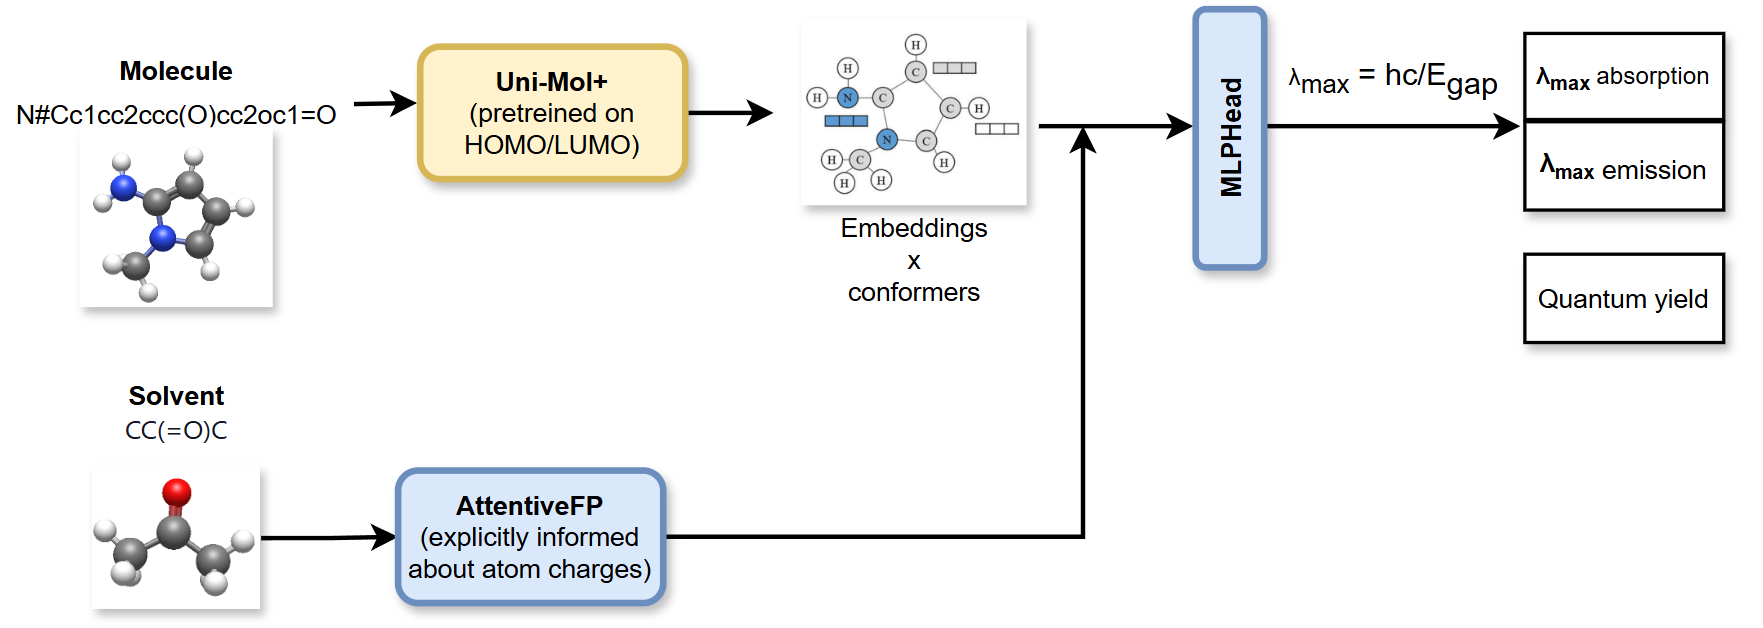

In [135]:
import torch.nn.functional as F
class custom_EnergyHead(nn.Module):
    def __init__(self, layer_norm, linear_in, input_dim, output_dim):
        super().__init__()
        self.layer_norm = layer_norm
        self.linear_in = linear_in
        self.linear_out = Linear(input_dim, 3, bias=True, init="default")

    def forward(self, x):
        x = x.type(self.linear_in.weight.dtype)
        x = F.gelu(self.layer_norm(self.linear_in(x)))
        x = self.linear_out(x)
        return x

In [149]:
(h * c)/(ev2joule) * 1e9

1240.7652456151302

In [240]:
from torch_geometric.nn.models import AttentiveFP
backbone = UnimolPlusPCQModel(args)
backbone.load_state_dict(state["ema"]["params"], strict=True)
h, c, ev2joule = 6.6261e-34, 3.00e8, 1.6021e-19
energy2wavelength = lambda E: 1240.7652456151302 * E
device = 'cpu'

solv_model_args = dict(in_channels = 40,
                   hidden_channels = args.embed_dim,
                   out_channels = args.embed_dim,
                   edge_dim = 10,
                   num_layers = 2,
                   num_timesteps = 1,
                   dropout = 0.3)

class UniMol_plus_finetune(nn.Module):
    def __init__(self):
        super().__init__()
        self.energy_head = custom_EnergyHead(backbone.energy_head.layer_norm,  backbone.energy_head.linear_in, args.embed_dim, 3).to(device)
        #self.energy_head = backbone.energy_head.to(device)
        self.solv_nn = solv_model.to(device)
        self.embeddigs = embedding_dict
        self.solv_embeddings = solv_data.dataset

    def forward(self, smiles_mol, smiles_solv):
        solv_input = solv_data.dataset[smiles_solv].to(device)
        solv_embedding = solv_eff_k*self.solv_nn(solv_input.x, solv_input.edge_index, solv_input.edge_attr, torch.tensor([0], device=solv_input.x.device)).relu()
        embedding = embedding_dict[smiles_mol].to(device).clone()
        for i in range(embedding.shape[0]):
            embedding[i] += solv_embedding
        gap = self.energy_head(embedding).mean(axis=0).mean(axis=0)
        wl = energy2wavelength(gap[:2])
        return torch.cat([wl, gap[2].view(1)])

In [241]:
#torch.cuda.empty_cache()
solv_eff_k = 0.1
solv_model = AttentiveFP(**solv_model_args)
mod = UniMol_plus_finetune()

In [256]:
pred = mod('N#Cc1cc2ccc(O)cc2oc1=O', 'O')
pred, df.loc[0, ['Absorption max (nm)', 'Emission max (nm)', 'Quantum yield']].values

(tensor([359.0892, 428.2898,   2.6333], grad_fn=<CatBackward0>),
 array([np.float64(355.0), np.float64(410.0), np.float64(nan)],
       dtype=object))

In [255]:
split = 9500
df_train, df_test = df.iloc[:split, :], df.iloc[split:, :]

In [266]:
get_data = lambda id, df: (df.loc[id, 'Chromophore'], df.loc[id, 'Solvent'], torch.tensor([df.loc[id, ['Absorption max (nm)', 'Emission max (nm)', 'Quantum yield']].values], dtype=torch.float32))
loss_fn = nn.L1Loss()
batch_size = 128
def train():
    i = 0
    sum_loss = []
    loss = torch.tensor(0., dtype=torch.float32, device=device)
    for id in tqdm(df_train.index):
        smiles_mol, smiles_solv, target = get_data(id, df_train)
        mask = ~torch.isnan(target)
        if mask.sum() == 0 or torch.isnan(mod.embeddigs[smiles_mol]).any():
            continue
        target.to(device), mask.to(device)
        target = target[mask]
        target = target.to(device)
        pred = mod(smiles_mol, smiles_solv)[mask[0]]
        loss += loss_fn(pred, target)
        i += 1
        if i == batch_size:
            #print(float(loss))
            sum_loss.append(float(loss))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss, i = torch.tensor(0., dtype=torch.float32, device=device), 0
    return np.array(sum_loss).mean()

@torch.no_grad()
def test():
    i = 0
    sum_loss = []
    loss = torch.tensor(0., dtype=torch.float32, device=device)
    for id in (df_test.index):
        smiles_mol, smiles_solv, target = get_data(id, df_test)
        mask = ~torch.isnan(target)
        if mask.sum() == 0 or torch.isnan(mod.embeddigs[smiles_mol]).any():
            continue
        target.to(device), mask.to(device)
        target = target[mask]
        target = target.to(device)
        pred = mod(smiles_mol, smiles_solv)[mask[0]]
        loss += loss_fn(pred, target)
        i += 1
        if i == batch_size:
            sum_loss.append(float(loss))
            loss, i = torch.tensor(0., dtype=torch.float32, device=device), 0
    return np.array(sum_loss).mean()

In [170]:
%%time
optimizer = torch.optim.Adam([*mod.energy_head.linear_out.parameters(), *mod.solv_nn.parameters()], lr=0.5e-3)
num_epochs = 50
history = dict(train=[], test=[])
for epoch in range(num_epochs):
    if epoch == 3:
        optimizer = torch.optim.Adam([*mod.energy_head.parameters(), *mod.solv_nn.parameters()], lr=1e-4)
        
    train_loss = train()
    test_loss = test()
    history['train'].append(train_loss), history['test'].append(test_loss)
    print(f"Epoch {epoch}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}")

  1%|█                                                                               | 127/9500 [00:07<06:33, 23.85it/s]

5823.7919921875


  3%|██                                                                              | 252/9500 [00:30<04:36, 33.39it/s]

21514.197265625


  4%|███▏                                                                            | 382/9500 [01:04<06:43, 22.59it/s]

10957.82421875


  5%|████▎                                                                           | 510/9500 [01:40<07:13, 20.76it/s]

7267.2783203125


  7%|█████▎                                                                          | 638/9500 [02:12<08:40, 17.02it/s]

11883.025390625


  8%|██████▍                                                                         | 767/9500 [02:46<05:49, 24.99it/s]

11924.50390625


  9%|███████▌                                                                        | 893/9500 [03:13<06:09, 23.32it/s]

9239.44921875


 11%|████████▍                                                                      | 1020/9500 [03:36<02:42, 52.22it/s]

7649.82763671875


 12%|█████████▌                                                                     | 1151/9500 [04:04<12:32, 11.09it/s]

8037.037109375


 13%|██████████▋                                                                    | 1278/9500 [04:37<03:29, 39.25it/s]

8300.400390625


 15%|███████████▋                                                                   | 1405/9500 [05:06<09:38, 14.00it/s]

8479.4775390625


 16%|████████████▊                                                                  | 1535/9500 [05:25<03:39, 36.31it/s]

7773.06787109375


 18%|█████████████▊                                                                 | 1663/9500 [05:45<05:25, 24.06it/s]

6628.74462890625


 19%|██████████████▊                                                                | 1788/9500 [06:03<04:11, 30.65it/s]

6667.96630859375


 20%|███████████████▉                                                               | 1916/9500 [06:20<02:58, 42.57it/s]

7199.93359375


 22%|████████████████▉                                                              | 2044/9500 [06:32<03:36, 34.44it/s]

7156.2802734375


 23%|██████████████████                                                             | 2172/9500 [06:52<04:03, 30.15it/s]

6371.95263671875


 24%|███████████████████▏                                                           | 2300/9500 [07:01<03:56, 30.40it/s]

7185.09765625


 26%|████████████████████▏                                                          | 2430/9500 [07:08<01:44, 67.69it/s]

7321.0419921875


 27%|█████████████████████▎                                                         | 2559/9500 [07:18<02:26, 47.36it/s]

7379.74072265625


 28%|██████████████████████▎                                                        | 2684/9500 [07:36<03:41, 30.80it/s]

6828.35986328125


 30%|███████████████████████▎                                                       | 2809/9500 [07:48<02:10, 51.40it/s]

6887.529296875


 31%|████████████████████████▍                                                      | 2941/9500 [08:10<05:13, 20.90it/s]

6729.537109375


 32%|█████████████████████████▌                                                     | 3069/9500 [08:35<04:36, 23.27it/s]

6579.97509765625


 34%|██████████████████████████▌                                                    | 3195/9500 [09:02<03:37, 28.95it/s]

6342.3701171875


 35%|███████████████████████████▋                                                   | 3326/9500 [09:22<02:57, 34.69it/s]

7028.86083984375


 36%|████████████████████████████▋                                                  | 3450/9500 [09:38<02:36, 38.58it/s]

5232.90234375


 38%|█████████████████████████████▊                                                 | 3581/9500 [10:09<05:59, 16.48it/s]

6027.1123046875


 39%|██████████████████████████████▊                                                | 3711/9500 [10:48<04:36, 20.92it/s]

5879.35888671875


 40%|███████████████████████████████▉                                               | 3836/9500 [11:16<02:20, 40.42it/s]

6391.73876953125


 42%|████████████████████████████████▉                                              | 3966/9500 [11:44<04:58, 18.53it/s]

5522.70556640625


 43%|██████████████████████████████████                                             | 4089/9500 [11:56<02:17, 39.28it/s]

5290.423828125


 44%|███████████████████████████████████                                            | 4221/9500 [12:21<04:55, 17.87it/s]

5558.64306640625


 46%|████████████████████████████████████▏                                          | 4345/9500 [12:44<01:51, 46.31it/s]

5724.62890625


 47%|█████████████████████████████████████▏                                         | 4473/9500 [13:06<01:48, 46.40it/s]

5375.6650390625


 48%|██████████████████████████████████████▎                                        | 4606/9500 [13:28<02:49, 28.89it/s]

5401.67919921875


 50%|███████████████████████████████████████▍                                       | 4735/9500 [13:56<03:42, 21.39it/s]

5599.37255859375


 51%|████████████████████████████████████████▍                                      | 4863/9500 [14:08<02:24, 32.02it/s]

5323.3330078125


 53%|█████████████████████████████████████████▍                                     | 4990/9500 [14:21<01:28, 50.86it/s]

5467.3642578125


 54%|██████████████████████████████████████████▌                                    | 5117/9500 [14:34<03:18, 22.09it/s]

5864.76513671875


 55%|███████████████████████████████████████████▌                                   | 5246/9500 [14:55<03:58, 17.87it/s]

5062.7158203125


 57%|████████████████████████████████████████████▋                                  | 5375/9500 [15:09<04:29, 15.29it/s]

5580.7841796875


 58%|█████████████████████████████████████████████▊                                 | 5503/9500 [15:25<04:05, 16.25it/s]

4827.5732421875


 59%|██████████████████████████████████████████████▊                                | 5628/9500 [15:45<02:55, 22.01it/s]

5946.61328125


 61%|███████████████████████████████████████████████▊                               | 5757/9500 [16:06<02:21, 26.39it/s]

5377.57275390625


 62%|████████████████████████████████████████████████▉                              | 5885/9500 [16:26<01:47, 33.75it/s]

5435.75732421875


 63%|██████████████████████████████████████████████████                             | 6013/9500 [17:00<02:32, 22.80it/s]

4985.9501953125


 65%|███████████████████████████████████████████████████                            | 6142/9500 [17:16<03:10, 17.63it/s]

5239.9765625


 66%|████████████████████████████████████████████████████                           | 6267/9500 [17:36<01:24, 38.13it/s]

5227.8125


 67%|█████████████████████████████████████████████████████▏                         | 6399/9500 [17:54<01:41, 30.52it/s]

5250.599609375


 69%|██████████████████████████████████████████████████████▎                        | 6526/9500 [18:11<01:32, 32.06it/s]

5846.609375


 70%|███████████████████████████████████████████████████████▎                       | 6654/9500 [18:32<01:47, 26.56it/s]

4376.75732421875


 71%|████████████████████████████████████████████████████████▍                      | 6783/9500 [18:52<00:46, 58.90it/s]

5984.71923828125


 73%|█████████████████████████████████████████████████████████▍                     | 6911/9500 [19:13<01:14, 34.91it/s]

5292.654296875


 74%|██████████████████████████████████████████████████████████▌                    | 7038/9500 [19:43<01:38, 24.94it/s]

4851.0029296875


 75%|███████████████████████████████████████████████████████████▌                   | 7167/9500 [20:05<01:35, 24.38it/s]

5933.72802734375


 77%|████████████████████████████████████████████████████████████▋                  | 7294/9500 [20:18<01:12, 30.24it/s]

5992.97607421875


 78%|█████████████████████████████████████████████████████████████▋                 | 7423/9500 [20:44<00:43, 48.14it/s]

5376.39013671875


 79%|██████████████████████████████████████████████████████████████▊                | 7550/9500 [20:53<01:24, 23.15it/s]

5450.6884765625


 81%|███████████████████████████████████████████████████████████████▊               | 7674/9500 [21:07<00:30, 59.27it/s]

5377.39990234375


 82%|████████████████████████████████████████████████████████████████▉              | 7805/9500 [21:20<00:39, 43.12it/s]

4819.3203125


 84%|█████████████████████████████████████████████████████████████████▉             | 7934/9500 [21:44<00:53, 29.01it/s]

5174.17578125


 85%|███████████████████████████████████████████████████████████████████            | 8061/9500 [22:06<00:57, 24.97it/s]

5381.02685546875


 86%|████████████████████████████████████████████████████████████████████           | 8188/9500 [22:30<00:51, 25.27it/s]

5403.80078125


 88%|█████████████████████████████████████████████████████████████████████▏         | 8318/9500 [22:55<00:54, 21.84it/s]

5191.60546875


 89%|██████████████████████████████████████████████████████████████████████▏        | 8444/9500 [23:20<00:23, 44.05it/s]

4488.73291015625


 90%|███████████████████████████████████████████████████████████████████████▎       | 8574/9500 [23:39<00:52, 17.62it/s]

5138.17626953125


 92%|████████████████████████████████████████████████████████████████████████▎      | 8701/9500 [24:08<00:26, 29.85it/s]

4720.84619140625


 93%|█████████████████████████████████████████████████████████████████████████▍     | 8830/9500 [24:30<00:13, 48.51it/s]

5344.1123046875


 94%|██████████████████████████████████████████████████████████████████████████▍    | 8957/9500 [24:47<00:27, 19.59it/s]

4618.20263671875


 96%|███████████████████████████████████████████████████████████████████████████▌   | 9086/9500 [25:00<00:09, 45.88it/s]

5591.08544921875


 97%|████████████████████████████████████████████████████████████████████████████▌  | 9210/9500 [25:07<00:07, 40.48it/s]

5027.31591796875


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 9340/9500 [25:21<00:04, 38.28it/s]

5376.77001953125


100%|██████████████████████████████████████████████████████████████████████████████▋| 9468/9500 [25:36<00:01, 31.01it/s]

4862.00048828125


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [25:47<00:00,  6.14it/s]


Epoch 0, train loss: 6383.4110, test loss: 5167.3221


  1%|█                                                                               | 127/9500 [00:05<06:18, 24.74it/s]

4999.10009765625


  3%|██▏                                                                             | 253/9500 [00:31<05:06, 30.15it/s]

5082.02978515625


  4%|███▏                                                                            | 382/9500 [00:45<02:35, 58.59it/s]

4628.85888671875


  5%|████▎                                                                           | 508/9500 [01:05<08:02, 18.63it/s]

4844.96044921875


  7%|█████▍                                                                          | 639/9500 [01:35<06:23, 23.11it/s]

5360.99169921875


  8%|██████▍                                                                         | 765/9500 [01:57<03:07, 46.60it/s]

5069.27734375


  9%|███████▌                                                                        | 894/9500 [02:06<05:11, 27.66it/s]

4902.07666015625


 11%|████████▍                                                                      | 1021/9500 [02:28<04:16, 33.11it/s]

5501.53857421875


 12%|█████████▌                                                                     | 1147/9500 [02:54<02:24, 57.88it/s]

5276.59912109375


 13%|██████████▋                                                                    | 1279/9500 [03:10<04:39, 29.43it/s]

4963.5146484375


 15%|███████████▋                                                                   | 1404/9500 [03:31<04:32, 29.66it/s]

5186.7109375


 16%|████████████▊                                                                  | 1535/9500 [03:53<06:50, 19.41it/s]

5275.7490234375


 18%|█████████████▊                                                                 | 1663/9500 [04:11<04:23, 29.78it/s]

5355.02001953125


 19%|██████████████▊                                                                | 1785/9500 [04:32<02:50, 45.37it/s]

4901.98095703125


 20%|███████████████▉                                                               | 1915/9500 [04:44<04:02, 31.26it/s]

5136.078125


 22%|████████████████▉                                                              | 2043/9500 [04:55<03:23, 36.66it/s]

5283.9443359375


 23%|██████████████████                                                             | 2173/9500 [05:11<02:34, 47.54it/s]

4913.4599609375


 24%|███████████████████                                                            | 2299/9500 [05:26<03:11, 37.53it/s]

6029.64599609375


 26%|████████████████████▏                                                          | 2424/9500 [05:37<02:17, 51.62it/s]

5296.82568359375


 27%|█████████████████████▏                                                         | 2555/9500 [05:47<03:17, 35.11it/s]

5057.21337890625


 28%|██████████████████████▎                                                        | 2683/9500 [05:57<02:21, 48.17it/s]

4835.36328125


 30%|███████████████████████▍                                                       | 2812/9500 [06:04<02:07, 52.57it/s]

5713.26953125


 31%|████████████████████████▍                                                      | 2938/9500 [06:17<01:57, 55.83it/s]

5113.150390625


 32%|█████████████████████████▌                                                     | 3068/9500 [06:30<02:50, 37.68it/s]

5185.5361328125


 34%|██████████████████████████▌                                                    | 3199/9500 [06:46<01:43, 61.15it/s]

4633.98046875


 35%|███████████████████████████▌                                                   | 3319/9500 [06:56<02:27, 42.04it/s]

5646.732421875


 36%|████████████████████████████▋                                                  | 3451/9500 [07:09<02:58, 33.81it/s]

4744.15771484375


 38%|█████████████████████████████▊                                                 | 3582/9500 [07:18<03:28, 28.40it/s]

5083.5087890625


 39%|██████████████████████████████▊                                                | 3709/9500 [07:34<03:17, 29.37it/s]

4714.7666015625


 40%|███████████████████████████████▉                                               | 3836/9500 [07:51<02:34, 36.61it/s]

5273.228515625


 42%|████████████████████████████████▉                                              | 3967/9500 [08:02<02:40, 34.44it/s]

5350.52294921875


 43%|██████████████████████████████████                                             | 4089/9500 [08:14<02:11, 41.21it/s]

4295.39599609375


 44%|███████████████████████████████████                                            | 4223/9500 [08:29<03:38, 24.13it/s]

4732.5556640625


 46%|████████████████████████████████████▏                                          | 4350/9500 [08:43<02:26, 35.13it/s]

4965.3720703125


 47%|█████████████████████████████████████▏                                         | 4477/9500 [08:57<01:08, 72.83it/s]

4581.64501953125


 48%|██████████████████████████████████████▎                                        | 4603/9500 [09:07<01:29, 54.51it/s]

4788.36767578125


 50%|███████████████████████████████████████▍                                       | 4735/9500 [09:19<02:07, 37.29it/s]

4913.8779296875


 51%|████████████████████████████████████████▍                                      | 4862/9500 [09:30<01:41, 45.59it/s]

4947.0966796875


 53%|█████████████████████████████████████████▍                                     | 4988/9500 [09:42<02:14, 33.56it/s]

4791.75732421875


 54%|██████████████████████████████████████████▌                                    | 5115/9500 [09:53<02:10, 33.53it/s]

5371.78662109375


 55%|███████████████████████████████████████████▌                                   | 5246/9500 [10:14<01:34, 44.85it/s]

4695.00244140625


 57%|████████████████████████████████████████████▋                                  | 5375/9500 [10:28<03:27, 19.90it/s]

5063.18701171875


 58%|█████████████████████████████████████████████▊                                 | 5502/9500 [10:54<04:48, 13.84it/s]

4617.97998046875


 59%|██████████████████████████████████████████████▊                                | 5627/9500 [11:08<01:37, 39.54it/s]

5646.88818359375


 61%|███████████████████████████████████████████████▊                               | 5755/9500 [11:19<02:02, 30.46it/s]

5269.5166015625


 62%|████████████████████████████████████████████████▉                              | 5886/9500 [11:36<01:48, 33.43it/s]

5069.9345703125


 63%|█████████████████████████████████████████████████▉                             | 6010/9500 [11:49<01:05, 53.06it/s]

4543.11865234375


 65%|███████████████████████████████████████████████████                            | 6139/9500 [11:56<01:11, 46.74it/s]

5325.22509765625


 66%|████████████████████████████████████████████████████▏                          | 6269/9500 [12:12<01:20, 39.97it/s]

4794.35107421875


 67%|█████████████████████████████████████████████████████▏                         | 6398/9500 [12:22<01:18, 39.32it/s]

5308.85205078125


 69%|██████████████████████████████████████████████████████▎                        | 6527/9500 [12:39<01:26, 34.37it/s]

5775.224609375


 70%|███████████████████████████████████████████████████████▎                       | 6651/9500 [12:46<00:55, 51.64it/s]

4423.5107421875


 71%|████████████████████████████████████████████████████████▍                      | 6783/9500 [12:54<00:47, 56.87it/s]

6008.3408203125


 73%|█████████████████████████████████████████████████████████▍                     | 6905/9500 [13:03<00:48, 53.39it/s]

4810.3828125


 74%|██████████████████████████████████████████████████████████▌                    | 7035/9500 [13:08<00:52, 46.55it/s]

4655.2216796875


 75%|███████████████████████████████████████████████████████████▌                   | 7163/9500 [13:24<01:11, 32.85it/s]

5608.41162109375


 77%|████████████████████████████████████████████████████████████▋                  | 7293/9500 [13:35<00:32, 67.21it/s]

5589.16015625


 78%|█████████████████████████████████████████████████████████████▋                 | 7417/9500 [13:46<00:36, 57.64it/s]

4963.501953125


 79%|██████████████████████████████████████████████████████████████▊                | 7550/9500 [13:55<00:39, 49.33it/s]

5150.83544921875


 81%|███████████████████████████████████████████████████████████████▊               | 7678/9500 [14:07<01:01, 29.57it/s]

5298.55224609375


 82%|████████████████████████████████████████████████████████████████▉              | 7802/9500 [14:21<00:37, 45.26it/s]

4788.1845703125


 84%|█████████████████████████████████████████████████████████████████▉             | 7933/9500 [14:44<00:44, 35.05it/s]

4769.37158203125


 85%|███████████████████████████████████████████████████████████████████            | 8062/9500 [14:52<00:26, 54.52it/s]

5163.01171875


 86%|████████████████████████████████████████████████████████████████████           | 8188/9500 [15:01<00:29, 44.17it/s]

5281.04541015625


 88%|█████████████████████████████████████████████████████████████████████▏         | 8316/9500 [15:10<00:30, 39.28it/s]

4917.63330078125


 89%|██████████████████████████████████████████████████████████████████████▏        | 8447/9500 [15:26<00:44, 23.88it/s]

4315.0205078125


 90%|███████████████████████████████████████████████████████████████████████▎       | 8572/9500 [15:41<00:15, 59.11it/s]

4540.3916015625


 92%|████████████████████████████████████████████████████████████████████████▎      | 8701/9500 [15:53<00:23, 34.51it/s]

4902.56298828125


 93%|█████████████████████████████████████████████████████████████████████████▍     | 8831/9500 [16:08<00:11, 59.33it/s]

5149.54638671875


 94%|██████████████████████████████████████████████████████████████████████████▌    | 8959/9500 [16:15<00:08, 64.12it/s]

4286.87060546875


 96%|███████████████████████████████████████████████████████████████████████████▌   | 9085/9500 [16:23<00:07, 57.27it/s]

5379.03662109375


 97%|████████████████████████████████████████████████████████████████████████████▋  | 9215/9500 [16:32<00:04, 58.57it/s]

4738.9853515625


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 9343/9500 [16:41<00:05, 29.79it/s]

4897.68505859375


100%|██████████████████████████████████████████████████████████████████████████████▊| 9470/9500 [16:50<00:00, 66.31it/s]

4666.9658203125


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [17:06<00:00,  9.26it/s]


Epoch 1, train loss: 5042.7183, test loss: 4733.0295


  1%|█                                                                               | 123/9500 [00:02<03:29, 44.69it/s]

4538.228515625


  3%|██                                                                              | 252/9500 [00:08<05:30, 27.95it/s]

4514.77197265625


  4%|███▏                                                                            | 378/9500 [00:19<03:12, 47.28it/s]

4577.275390625


  5%|████▎                                                                           | 509/9500 [00:31<05:03, 29.62it/s]

4639.77587890625


  7%|█████▍                                                                          | 639/9500 [00:46<04:29, 32.83it/s]

5307.541015625


  8%|██████▍                                                                         | 766/9500 [00:54<01:39, 87.58it/s]

4779.880859375


  9%|███████▌                                                                        | 895/9500 [01:01<01:47, 79.88it/s]

4677.57666015625


 11%|████████▍                                                                      | 1022/9500 [01:11<03:09, 44.85it/s]

5111.626953125


 12%|█████████▌                                                                     | 1151/9500 [01:24<04:11, 33.25it/s]

5018.43017578125


 13%|██████████▌                                                                    | 1277/9500 [01:35<03:08, 43.60it/s]

4724.93310546875


 15%|███████████▋                                                                   | 1404/9500 [01:43<03:20, 40.40it/s]

5078.25830078125


 16%|████████████▊                                                                  | 1535/9500 [01:53<03:59, 33.33it/s]

5271.1630859375


 17%|█████████████▊                                                                 | 1660/9500 [02:07<02:19, 56.03it/s]

4736.70068359375


 19%|██████████████▊                                                                | 1787/9500 [02:18<01:57, 65.44it/s]

4662.728515625


 20%|███████████████▉                                                               | 1918/9500 [02:29<03:50, 32.96it/s]

4651.57373046875


 22%|█████████████████                                                              | 2045/9500 [02:36<03:24, 36.54it/s]

4881.42626953125


 23%|██████████████████                                                             | 2172/9500 [02:50<02:15, 53.89it/s]

4640.20947265625


 24%|███████████████████▏                                                           | 2303/9500 [02:56<02:11, 54.62it/s]

5622.03271484375


 26%|████████████████████▏                                                          | 2426/9500 [03:04<01:51, 63.40it/s]

4843.78515625


 27%|█████████████████████▎                                                         | 2558/9500 [03:14<02:00, 57.83it/s]

4823.73974609375


 28%|██████████████████████▎                                                        | 2682/9500 [03:22<01:39, 68.42it/s]

4459.916015625


 30%|███████████████████████▍                                                       | 2814/9500 [03:27<02:43, 40.89it/s]

5439.89453125


 31%|████████████████████████▍                                                      | 2941/9500 [03:37<02:11, 49.88it/s]

4827.32177734375


 32%|█████████████████████████▌                                                     | 3069/9500 [03:49<01:25, 75.36it/s]

4933.96142578125


 34%|██████████████████████████▌                                                    | 3193/9500 [03:57<01:39, 63.15it/s]

4386.4208984375


 35%|███████████████████████████▌                                                   | 3320/9500 [04:05<01:25, 72.02it/s]

5341.7939453125


 36%|████████████████████████████▋                                                  | 3451/9500 [04:10<01:34, 64.19it/s]

4690.7978515625


 38%|█████████████████████████████▊                                                 | 3579/9500 [04:19<02:24, 41.11it/s]

4880.36767578125


 39%|██████████████████████████████▊                                                | 3707/9500 [04:35<04:08, 23.32it/s]

4532.17236328125


 40%|███████████████████████████████▉                                               | 3835/9500 [05:05<03:27, 27.30it/s]

5370.96875


 42%|████████████████████████████████▉                                              | 3964/9500 [05:23<02:03, 44.65it/s]

4679.83740234375


 43%|██████████████████████████████████                                             | 4093/9500 [05:38<02:30, 35.86it/s]

4543.35546875


 44%|███████████████████████████████████                                            | 4222/9500 [05:58<03:14, 27.16it/s]

4468.13232421875


 46%|████████████████████████████████████▏                                          | 4350/9500 [06:13<02:16, 37.64it/s]

4464.556640625


 47%|█████████████████████████████████████▏                                         | 4479/9500 [06:28<02:41, 31.08it/s]

4587.55615234375


 48%|██████████████████████████████████████▎                                        | 4606/9500 [06:40<05:21, 15.24it/s]

4582.08935546875


 50%|███████████████████████████████████████▎                                       | 4730/9500 [06:53<03:04, 25.83it/s]

4671.1171875


 51%|████████████████████████████████████████▍                                      | 4862/9500 [07:06<03:20, 23.08it/s]

4854.06396484375


 52%|█████████████████████████████████████████▍                                     | 4987/9500 [07:15<01:50, 40.96it/s]

4589.86669921875


 54%|██████████████████████████████████████████▌                                    | 5119/9500 [07:31<01:13, 59.68it/s]

5235.03271484375


 55%|███████████████████████████████████████████▌                                   | 5242/9500 [07:35<01:04, 65.83it/s]

4464.0185546875


 57%|████████████████████████████████████████████▋                                  | 5369/9500 [07:51<01:13, 55.85it/s]

4635.880859375


 58%|█████████████████████████████████████████████▊                                 | 5503/9500 [08:00<02:04, 32.22it/s]

4679.2978515625


 59%|██████████████████████████████████████████████▊                                | 5627/9500 [08:09<01:31, 42.38it/s]

5037.7939453125


 61%|███████████████████████████████████████████████▊                               | 5756/9500 [08:22<02:09, 28.95it/s]

4821.818359375


 62%|████████████████████████████████████████████████▉                              | 5885/9500 [08:31<00:42, 85.36it/s]

4698.92626953125


 63%|█████████████████████████████████████████████████▉                             | 6011/9500 [08:41<01:08, 50.64it/s]

4100.951171875


 65%|███████████████████████████████████████████████████                            | 6143/9500 [08:55<01:40, 33.34it/s]

5111.5986328125


 66%|████████████████████████████████████████████████████▏                          | 6270/9500 [09:10<01:54, 28.10it/s]

4610.748046875


 67%|█████████████████████████████████████████████████████▏                         | 6396/9500 [09:20<01:36, 32.31it/s]

4710.6953125


 69%|██████████████████████████████████████████████████████▎                        | 6527/9500 [09:28<01:36, 30.75it/s]

5835.67431640625


 70%|███████████████████████████████████████████████████████▎                       | 6653/9500 [09:33<00:42, 67.56it/s]

4523.85498046875


 71%|████████████████████████████████████████████████████████▍                      | 6782/9500 [09:41<00:59, 45.42it/s]

6272.748046875


 73%|█████████████████████████████████████████████████████████▍                     | 6910/9500 [09:49<00:37, 69.62it/s]

5036.515625


 74%|██████████████████████████████████████████████████████████▍                    | 7028/9500 [09:57<00:59, 41.54it/s]

4468.02587890625


 75%|███████████████████████████████████████████████████████████▌                   | 7167/9500 [10:03<00:42, 55.08it/s]

5656.2119140625


 77%|████████████████████████████████████████████████████████████▋                  | 7295/9500 [10:11<00:36, 60.68it/s]

5423.79248046875


 78%|█████████████████████████████████████████████████████████████▋                 | 7417/9500 [10:20<00:54, 37.95it/s]

4561.61279296875


 79%|██████████████████████████████████████████████████████████████▊                | 7546/9500 [10:29<00:40, 48.42it/s]

4670.10498046875


 81%|███████████████████████████████████████████████████████████████▊               | 7677/9500 [10:37<01:17, 23.44it/s]

4913.8447265625


 82%|████████████████████████████████████████████████████████████████▉              | 7804/9500 [10:49<00:26, 63.16it/s]

4436.24658203125


 83%|█████████████████████████████████████████████████████████████████▉             | 7930/9500 [10:58<00:21, 72.07it/s]

4406.74072265625


 85%|███████████████████████████████████████████████████████████████████            | 8061/9500 [11:13<01:23, 17.17it/s]

4866.19482421875


 86%|████████████████████████████████████████████████████████████████████           | 8187/9500 [11:22<00:32, 40.50it/s]

4991.6103515625


 88%|█████████████████████████████████████████████████████████████████████▏         | 8319/9500 [11:34<00:25, 45.88it/s]

4641.994140625


 89%|██████████████████████████████████████████████████████████████████████▏        | 8447/9500 [11:41<00:25, 41.63it/s]

4267.837890625


 90%|███████████████████████████████████████████████████████████████████████▎       | 8574/9500 [11:51<00:15, 61.60it/s]

4696.67822265625


 92%|████████████████████████████████████████████████████████████████████████▎      | 8701/9500 [11:58<00:18, 44.02it/s]

4107.9658203125


 93%|█████████████████████████████████████████████████████████████████████████▍     | 8830/9500 [12:06<00:13, 51.32it/s]

5019.447265625


 94%|██████████████████████████████████████████████████████████████████████████▍    | 8955/9500 [12:26<00:12, 43.09it/s]

4148.0322265625


 96%|███████████████████████████████████████████████████████████████████████████▌   | 9084/9500 [12:47<00:07, 53.77it/s]

5159.24365234375


 97%|████████████████████████████████████████████████████████████████████████████▌  | 9212/9500 [12:58<00:09, 30.38it/s]

4628.7431640625


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 9339/9500 [13:13<00:03, 42.40it/s]

4825.5390625


100%|██████████████████████████████████████████████████████████████████████████████▋| 9469/9500 [13:25<00:00, 36.18it/s]

4647.35595703125


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [13:32<00:00, 11.69it/s]


Epoch 2, train loss: 4807.0085, test loss: 4550.0631


  1%|█                                                                               | 123/9500 [00:02<02:35, 60.29it/s]

4313.69677734375


  3%|██                                                                              | 250/9500 [00:07<03:09, 48.71it/s]

6790.72705078125


  4%|███▏                                                                            | 381/9500 [00:16<02:18, 66.08it/s]

5878.443359375


  5%|████▎                                                                           | 505/9500 [00:29<02:45, 54.21it/s]

4702.05419921875


  7%|█████▎                                                                          | 632/9500 [00:41<02:21, 62.81it/s]

6529.67138671875


  8%|██████▍                                                                         | 766/9500 [00:47<03:44, 38.91it/s]

6174.1572265625


  9%|███████▌                                                                        | 895/9500 [00:57<03:54, 36.64it/s]

4981.35986328125


 11%|████████▍                                                                      | 1022/9500 [01:05<04:48, 29.36it/s]

4735.78955078125


 12%|█████████▌                                                                     | 1147/9500 [01:14<03:43, 37.35it/s]

5245.53564453125


 13%|██████████▌                                                                    | 1274/9500 [01:29<02:19, 59.08it/s]

5104.88671875


 15%|███████████▋                                                                   | 1402/9500 [01:37<01:57, 69.14it/s]

5582.36328125


 16%|████████████▊                                                                  | 1535/9500 [01:47<02:59, 44.45it/s]

5335.15771484375


 17%|█████████████▋                                                                 | 1652/9500 [01:57<01:34, 83.15it/s]

4628.4365234375


 19%|██████████████▊                                                                | 1788/9500 [02:03<03:45, 34.27it/s]

4394.62109375


 20%|███████████████▉                                                               | 1916/9500 [02:12<02:43, 46.38it/s]

4465.48046875


 21%|████████████████▉                                                              | 2039/9500 [02:26<02:51, 43.50it/s]

4931.390625


 23%|██████████████████                                                             | 2173/9500 [02:35<01:41, 71.84it/s]

4445.70703125


 24%|███████████████████                                                            | 2296/9500 [02:41<02:00, 59.99it/s]

5557.44384765625


 26%|████████████████████▏                                                          | 2426/9500 [02:53<02:58, 39.57it/s]

4537.220703125


 27%|█████████████████████▏                                                         | 2553/9500 [02:59<02:57, 39.19it/s]

4651.41162109375


 28%|██████████████████████▎                                                        | 2686/9500 [03:08<02:39, 42.82it/s]

4293.35009765625


 30%|███████████████████████▍                                                       | 2813/9500 [03:20<03:00, 37.11it/s]

5432.89306640625


 31%|████████████████████████▍                                                      | 2939/9500 [03:31<03:15, 33.53it/s]

4825.28369140625


 32%|█████████████████████████▌                                                     | 3070/9500 [03:50<02:41, 39.87it/s]

4739.0029296875


 34%|██████████████████████████▌                                                    | 3199/9500 [03:58<02:25, 43.31it/s]

4149.265625


 35%|███████████████████████████▋                                                   | 3324/9500 [04:04<01:27, 70.62it/s]

4878.61279296875


 36%|████████████████████████████▋                                                  | 3453/9500 [04:10<01:30, 66.60it/s]

4174.185546875


 38%|█████████████████████████████▊                                                 | 3581/9500 [04:18<01:36, 61.08it/s]

5036.45556640625


 39%|██████████████████████████████▊                                                | 3710/9500 [04:25<01:39, 57.99it/s]

4372.611328125


 40%|███████████████████████████████▉                                               | 3836/9500 [04:35<01:36, 58.97it/s]

4721.15869140625


 42%|████████████████████████████████▉                                              | 3964/9500 [04:44<02:09, 42.88it/s]

4241.2197265625


 43%|██████████████████████████████████                                             | 4091/9500 [04:50<01:20, 67.41it/s]

4082.580078125


 44%|███████████████████████████████████                                            | 4223/9500 [04:56<01:18, 67.42it/s]

4252.62841796875


 46%|████████████████████████████████████▏                                          | 4350/9500 [05:05<02:03, 41.80it/s]

4320.0693359375


 47%|█████████████████████████████████████▏                                         | 4475/9500 [05:12<02:01, 41.41it/s]

3890.111572265625


 48%|██████████████████████████████████████▎                                        | 4603/9500 [05:20<02:05, 38.87it/s]

4237.1875


 50%|███████████████████████████████████████▎                                       | 4731/9500 [05:31<02:37, 30.37it/s]

4344.57275390625


 51%|████████████████████████████████████████▍                                      | 4861/9500 [05:41<01:44, 44.53it/s]

4632.087890625


 53%|█████████████████████████████████████████▍                                     | 4988/9500 [05:49<01:08, 65.79it/s]

4344.91259765625


 54%|██████████████████████████████████████████▌                                    | 5115/9500 [05:56<01:56, 37.78it/s]

4808.01025390625


 55%|███████████████████████████████████████████▌                                   | 5243/9500 [06:07<01:16, 55.93it/s]

3886.008544921875


 57%|████████████████████████████████████████████▋                                  | 5371/9500 [06:12<01:14, 55.53it/s]

4297.20166015625


 58%|█████████████████████████████████████████████▋                                 | 5495/9500 [06:22<00:54, 73.33it/s]

3888.27001953125


 59%|██████████████████████████████████████████████▊                                | 5629/9500 [06:33<01:13, 52.57it/s]

4615.51708984375


 61%|███████████████████████████████████████████████▊                               | 5753/9500 [06:41<01:28, 42.28it/s]

4370.1044921875


 62%|████████████████████████████████████████████████▉                              | 5882/9500 [06:58<01:29, 40.24it/s]

4144.359375


 63%|█████████████████████████████████████████████████▉                             | 6010/9500 [07:03<01:01, 56.77it/s]

3667.9453125


 65%|███████████████████████████████████████████████████                            | 6138/9500 [07:09<01:18, 42.82it/s]

4585.556640625


 66%|████████████████████████████████████████████████████                           | 6267/9500 [07:18<00:52, 61.94it/s]

4067.55908203125


 67%|█████████████████████████████████████████████████████▏                         | 6398/9500 [07:29<01:19, 39.00it/s]

4218.4306640625


 69%|██████████████████████████████████████████████████████▎                        | 6526/9500 [07:35<00:52, 56.27it/s]

4687.77685546875


 70%|███████████████████████████████████████████████████████▎                       | 6652/9500 [07:46<01:41, 28.18it/s]

3447.039794921875


 71%|████████████████████████████████████████████████████████▍                      | 6780/9500 [07:56<00:48, 56.33it/s]

5034.345703125


 73%|█████████████████████████████████████████████████████████▍                     | 6907/9500 [08:09<00:41, 63.11it/s]

4054.9033203125


 74%|██████████████████████████████████████████████████████████▍                    | 7034/9500 [08:14<00:37, 65.89it/s]

3882.742919921875


 75%|███████████████████████████████████████████████████████████▌                   | 7164/9500 [08:27<01:04, 36.01it/s]

4810.10693359375


 77%|████████████████████████████████████████████████████████████▌                  | 7290/9500 [08:47<00:43, 50.54it/s]

4780.6044921875


 78%|█████████████████████████████████████████████████████████████▋                 | 7420/9500 [08:54<00:49, 41.74it/s]

3955.2841796875


 79%|██████████████████████████████████████████████████████████████▊                | 7551/9500 [09:09<00:38, 50.31it/s]

4371.3330078125


 81%|███████████████████████████████████████████████████████████████▊               | 7676/9500 [09:21<00:40, 45.08it/s]

4243.5859375


 82%|████████████████████████████████████████████████████████████████▉              | 7805/9500 [09:32<00:41, 41.16it/s]

3819.15576171875


 83%|█████████████████████████████████████████████████████████████████▉             | 7930/9500 [09:40<00:26, 58.81it/s]

3902.84765625


 85%|███████████████████████████████████████████████████████████████████            | 8060/9500 [09:55<00:21, 68.43it/s]

4244.80224609375


 86%|████████████████████████████████████████████████████████████████████           | 8185/9500 [10:05<00:27, 47.77it/s]

4603.50390625


 88%|█████████████████████████████████████████████████████████████████████▏         | 8315/9500 [10:18<00:20, 57.35it/s]

3946.738037109375


 89%|██████████████████████████████████████████████████████████████████████▏        | 8447/9500 [10:26<00:24, 42.27it/s]

3647.222412109375


 90%|███████████████████████████████████████████████████████████████████████▎       | 8575/9500 [10:32<00:13, 66.66it/s]

4002.09130859375


 92%|████████████████████████████████████████████████████████████████████████▎      | 8703/9500 [10:42<00:21, 37.77it/s]

3647.723876953125


 93%|█████████████████████████████████████████████████████████████████████████▍     | 8830/9500 [10:50<00:17, 37.89it/s]

4288.849609375


 94%|██████████████████████████████████████████████████████████████████████████▍    | 8954/9500 [11:06<00:14, 37.60it/s]

3563.493896484375


 96%|███████████████████████████████████████████████████████████████████████████▌   | 9085/9500 [11:15<00:13, 30.82it/s]

4603.9853515625


 97%|████████████████████████████████████████████████████████████████████████████▌  | 9214/9500 [11:26<00:04, 57.74it/s]

3895.58251953125


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 9339/9500 [11:32<00:02, 69.90it/s]

4274.82568359375


100%|██████████████████████████████████████████████████████████████████████████████▋| 9469/9500 [11:45<00:00, 32.89it/s]

3981.595458984375


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [11:56<00:00, 13.25it/s]


Epoch 3, train loss: 4516.1196, test loss: 3996.4591


  1%|█                                                                               | 124/9500 [00:02<02:41, 57.89it/s]

3582.379638671875


  3%|██▏                                                                             | 254/9500 [00:10<03:40, 41.90it/s]

3724.1640625


  4%|███▏                                                                            | 381/9500 [00:20<02:22, 63.82it/s]

3612.813232421875


  5%|████▎                                                                           | 508/9500 [00:27<02:45, 54.20it/s]

3650.765625


  7%|█████▎                                                                          | 637/9500 [00:35<02:42, 54.64it/s]

4260.4873046875


  8%|██████▍                                                                         | 762/9500 [00:44<02:44, 53.26it/s]

3891.76513671875


  9%|███████▍                                                                        | 889/9500 [00:50<02:01, 70.85it/s]

3728.998291015625


 11%|████████▍                                                                      | 1016/9500 [00:54<01:57, 72.42it/s]

4489.54345703125


 12%|█████████▌                                                                     | 1147/9500 [00:59<01:55, 72.21it/s]

4257.11767578125


 13%|██████████▌                                                                    | 1269/9500 [01:03<02:07, 64.75it/s]

4167.701171875


 15%|███████████▋                                                                   | 1402/9500 [01:08<02:21, 57.08it/s]

4297.34375


 16%|████████████▋                                                                  | 1531/9500 [01:17<04:25, 29.98it/s]

4003.96337890625


 17%|█████████████▊                                                                 | 1661/9500 [01:23<03:10, 41.18it/s]

3943.995361328125


 19%|██████████████▊                                                                | 1784/9500 [01:33<02:11, 58.89it/s]

3920.505615234375


 20%|███████████████▉                                                               | 1914/9500 [01:40<02:02, 61.84it/s]

3818.41845703125


 21%|████████████████▉                                                              | 2042/9500 [01:46<02:20, 53.08it/s]

4184.89599609375


 23%|██████████████████                                                             | 2170/9500 [01:54<01:49, 66.67it/s]

3832.63720703125


 24%|███████████████████▏                                                           | 2300/9500 [01:59<02:05, 57.36it/s]

4595.65869140625


 26%|████████████████████▏                                                          | 2428/9500 [02:07<02:57, 39.88it/s]

3810.11962890625


 27%|█████████████████████▎                                                         | 2559/9500 [02:15<02:00, 57.82it/s]

3886.126708984375


 28%|██████████████████████▎                                                        | 2681/9500 [02:27<02:01, 55.92it/s]

3616.625


 30%|███████████████████████▎                                                       | 2808/9500 [02:37<02:15, 49.31it/s]

4644.748046875


 31%|████████████████████████▍                                                      | 2942/9500 [02:49<02:47, 39.13it/s]

4103.22607421875


 32%|█████████████████████████▌                                                     | 3067/9500 [02:59<02:52, 37.24it/s]

4064.07373046875


 34%|██████████████████████████▌                                                    | 3196/9500 [03:09<02:05, 50.29it/s]

3542.741455078125


 35%|███████████████████████████▋                                                   | 3327/9500 [03:14<02:22, 43.39it/s]

4269.0126953125


 36%|████████████████████████████▋                                                  | 3454/9500 [03:19<01:27, 68.75it/s]

3785.4423828125


 38%|█████████████████████████████▊                                                 | 3582/9500 [03:27<02:29, 39.69it/s]

4175.81884765625


 39%|██████████████████████████████▊                                                | 3706/9500 [03:37<02:21, 40.82it/s]

3754.820068359375


 40%|███████████████████████████████▉                                               | 3835/9500 [03:44<01:31, 61.91it/s]

4162.1220703125


 42%|████████████████████████████████▉                                              | 3963/9500 [03:55<02:27, 37.47it/s]

3941.767578125


 43%|██████████████████████████████████                                             | 4089/9500 [04:02<01:26, 62.23it/s]

3455.50927734375


 44%|███████████████████████████████████                                            | 4218/9500 [04:07<01:42, 51.33it/s]

3620.363525390625


 46%|████████████████████████████████████▏                                          | 4350/9500 [04:12<02:06, 40.80it/s]

3656.324951171875


 47%|█████████████████████████████████████▏                                         | 4476/9500 [04:18<01:24, 59.11it/s]

3383.223876953125


 48%|██████████████████████████████████████▎                                        | 4606/9500 [04:26<01:20, 61.06it/s]

3851.42431640625


 50%|███████████████████████████████████████▎                                       | 4729/9500 [04:33<02:15, 35.22it/s]

4003.19873046875


 51%|████████████████████████████████████████▍                                      | 4859/9500 [04:47<01:47, 43.09it/s]

4130.3251953125


 52%|█████████████████████████████████████████▍                                     | 4985/9500 [04:56<01:23, 54.00it/s]

3555.8369140625


 54%|██████████████████████████████████████████▌                                    | 5118/9500 [05:03<02:04, 35.22it/s]

4397.22509765625


 55%|███████████████████████████████████████████▌                                   | 5246/9500 [05:12<01:22, 51.87it/s]

3493.238037109375


 57%|████████████████████████████████████████████▋                                  | 5373/9500 [05:24<01:51, 36.93it/s]

3773.151123046875


 58%|█████████████████████████████████████████████▊                                 | 5503/9500 [05:36<02:16, 29.22it/s]

3499.734619140625


 59%|██████████████████████████████████████████████▊                                | 5630/9500 [05:52<01:40, 38.39it/s]

4178.33447265625


 61%|███████████████████████████████████████████████▊                               | 5755/9500 [06:04<01:34, 39.63it/s]

3777.784423828125


 62%|████████████████████████████████████████████████▉                              | 5885/9500 [06:18<01:31, 39.67it/s]

3731.4951171875


 63%|█████████████████████████████████████████████████▉                             | 6010/9500 [06:27<01:08, 51.21it/s]

3298.80078125


 65%|███████████████████████████████████████████████████                            | 6139/9500 [06:33<01:14, 45.11it/s]

3957.3662109375


 66%|████████████████████████████████████████████████████                           | 6267/9500 [06:43<01:07, 47.70it/s]

3677.587646484375


 67%|█████████████████████████████████████████████████████▏                         | 6395/9500 [06:49<01:10, 43.90it/s]

3641.783447265625


 69%|██████████████████████████████████████████████████████▏                        | 6521/9500 [06:59<00:55, 53.58it/s]

4199.3232421875


 70%|███████████████████████████████████████████████████████▎                       | 6651/9500 [07:08<00:43, 64.95it/s]

3176.874755859375


 71%|████████████████████████████████████████████████████████▎                      | 6775/9500 [07:17<00:46, 58.16it/s]

4491.8662109375


 73%|█████████████████████████████████████████████████████████▍                     | 6910/9500 [07:24<00:38, 66.69it/s]

3771.0234375


 74%|██████████████████████████████████████████████████████████▌                    | 7037/9500 [07:32<01:03, 38.89it/s]

3664.1044921875


 75%|███████████████████████████████████████████████████████████▌                   | 7166/9500 [07:40<00:33, 69.83it/s]

4197.3505859375


 77%|████████████████████████████████████████████████████████████▋                  | 7294/9500 [07:47<00:50, 43.50it/s]

4335.3505859375


 78%|█████████████████████████████████████████████████████████████▋                 | 7420/9500 [07:57<00:49, 42.20it/s]

3584.212890625


 79%|██████████████████████████████████████████████████████████████▋                | 7545/9500 [08:01<00:29, 66.29it/s]

4152.90771484375


 81%|███████████████████████████████████████████████████████████████▊               | 7675/9500 [08:12<00:40, 45.24it/s]

3812.302978515625


 82%|████████████████████████████████████████████████████████████████▊              | 7800/9500 [08:18<00:23, 71.11it/s]

3574.97607421875


 83%|█████████████████████████████████████████████████████████████████▉             | 7932/9500 [08:27<00:33, 46.33it/s]

3946.263427734375


 85%|███████████████████████████████████████████████████████████████████            | 8058/9500 [08:34<00:21, 67.34it/s]

3933.12060546875


 86%|████████████████████████████████████████████████████████████████████           | 8189/9500 [08:40<00:20, 64.68it/s]

4167.23583984375


 88%|█████████████████████████████████████████████████████████████████████▏         | 8314/9500 [08:46<00:16, 69.91it/s]

3656.365966796875


 89%|██████████████████████████████████████████████████████████████████████▏        | 8447/9500 [08:57<00:21, 48.48it/s]

3452.6982421875


 90%|███████████████████████████████████████████████████████████████████████▎       | 8571/9500 [09:05<00:12, 72.64it/s]

3632.84716796875


 92%|████████████████████████████████████████████████████████████████████████▎      | 8703/9500 [09:17<00:19, 40.34it/s]

3443.823486328125


 93%|█████████████████████████████████████████████████████████████████████████▍     | 8828/9500 [09:25<00:14, 44.87it/s]

4018.783203125


 94%|██████████████████████████████████████████████████████████████████████████▍    | 8954/9500 [09:31<00:08, 65.99it/s]

3368.094482421875


 96%|███████████████████████████████████████████████████████████████████████████▌   | 9084/9500 [09:37<00:10, 39.91it/s]

4157.56591796875


 97%|████████████████████████████████████████████████████████████████████████████▌  | 9213/9500 [09:43<00:09, 30.66it/s]

3497.9375


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 9339/9500 [09:50<00:04, 40.13it/s]

3776.679931640625


100%|██████████████████████████████████████████████████████████████████████████████▊| 9470/9500 [10:03<00:00, 35.06it/s]

3646.010986328125


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [10:10<00:00, 15.57it/s]


Epoch 4, train loss: 3871.0841, test loss: 3659.4079


  1%|█                                                                               | 124/9500 [00:03<04:05, 38.22it/s]

3216.19482421875


  3%|██                                                                              | 251/9500 [00:12<02:32, 60.56it/s]

3567.89794921875


  4%|███▏                                                                            | 376/9500 [00:18<02:06, 72.11it/s]

3213.780517578125


  5%|████▎                                                                           | 511/9500 [00:46<05:12, 28.78it/s]

3504.5712890625


  7%|█████▎                                                                          | 638/9500 [00:53<02:15, 65.47it/s]

3853.636962890625


  8%|██████▍                                                                         | 766/9500 [00:59<03:21, 43.29it/s]

3806.07763671875


  9%|███████▌                                                                        | 893/9500 [01:10<03:11, 45.01it/s]

3394.568359375


 11%|████████▍                                                                      | 1018/9500 [01:17<03:01, 46.61it/s]

4083.56396484375


 12%|█████████▌                                                                     | 1151/9500 [01:22<02:02, 67.98it/s]

3934.10986328125


 13%|██████████▌                                                                    | 1274/9500 [01:32<02:44, 49.98it/s]

3872.7275390625


 15%|███████████▋                                                                   | 1406/9500 [01:46<05:01, 26.87it/s]

3977.845947265625


 16%|████████████▋                                                                  | 1533/9500 [01:57<03:09, 42.03it/s]

3651.63134765625


 17%|█████████████▊                                                                 | 1658/9500 [02:02<02:15, 58.05it/s]

3641.771484375


 19%|██████████████▉                                                                | 1790/9500 [02:11<02:35, 49.64it/s]

3653.3779296875


 20%|███████████████▉                                                               | 1915/9500 [02:19<03:11, 39.71it/s]

3439.383544921875


 22%|█████████████████                                                              | 2047/9500 [02:27<01:54, 65.24it/s]

3803.23095703125


 23%|██████████████████                                                             | 2172/9500 [02:31<02:19, 52.52it/s]

3427.162109375


 24%|███████████████████▏                                                           | 2301/9500 [02:38<02:24, 49.72it/s]

4132.92431640625


 26%|████████████████████▏                                                          | 2428/9500 [02:46<03:25, 34.40it/s]

3549.78076171875


 27%|█████████████████████▏                                                         | 2555/9500 [02:51<02:35, 44.54it/s]

3617.992919921875


 28%|██████████████████████▎                                                        | 2687/9500 [02:59<03:22, 33.58it/s]

3276.51416015625


 30%|███████████████████████▍                                                       | 2813/9500 [03:12<03:42, 30.04it/s]

4242.41357421875


 31%|████████████████████████▍                                                      | 2939/9500 [03:20<02:29, 44.02it/s]

3468.51904296875


 32%|█████████████████████████▌                                                     | 3067/9500 [03:25<03:14, 33.15it/s]

3740.74560546875


 34%|██████████████████████████▌                                                    | 3198/9500 [03:31<02:16, 46.11it/s]

3389.71337890625


 35%|███████████████████████████▋                                                   | 3323/9500 [03:41<01:42, 60.23it/s]

3846.81298828125


 36%|████████████████████████████▋                                                  | 3452/9500 [03:48<03:40, 27.49it/s]

3447.189697265625


 38%|█████████████████████████████▊                                                 | 3581/9500 [03:56<01:28, 67.18it/s]

3727.411376953125


 39%|██████████████████████████████▊                                                | 3709/9500 [04:04<02:11, 43.88it/s]

3223.04296875


 40%|███████████████████████████████▉                                               | 3839/9500 [04:11<02:12, 42.80it/s]

3955.234619140625


 42%|████████████████████████████████▉                                              | 3966/9500 [04:19<02:38, 34.82it/s]

3739.6005859375


 43%|█████████████████████████████████▉                                             | 4084/9500 [04:30<00:59, 91.02it/s]

3118.196533203125


 44%|███████████████████████████████████                                            | 4223/9500 [04:36<01:27, 60.10it/s]

3365.011962890625


 46%|████████████████████████████████████▏                                          | 4350/9500 [04:45<03:08, 27.38it/s]

3441.69482421875


 47%|█████████████████████████████████████▏                                         | 4478/9500 [04:56<01:10, 71.17it/s]

3069.4296875


 48%|██████████████████████████████████████▎                                        | 4600/9500 [05:01<01:07, 73.07it/s]

3787.805419921875


 50%|███████████████████████████████████████▎                                       | 4732/9500 [05:06<01:04, 73.67it/s]

3713.037353515625


 51%|████████████████████████████████████████▍                                      | 4859/9500 [05:12<01:30, 51.38it/s]

3596.7314453125


 53%|█████████████████████████████████████████▍                                     | 4990/9500 [05:26<01:30, 49.84it/s]

3334.94677734375


 54%|██████████████████████████████████████████▌                                    | 5114/9500 [05:47<01:28, 49.40it/s]

4215.19384765625


 55%|███████████████████████████████████████████▌                                   | 5242/9500 [05:56<02:07, 33.38it/s]

3229.490966796875


 57%|████████████████████████████████████████████▋                                  | 5371/9500 [06:01<01:17, 53.42it/s]

3566.673828125


 58%|█████████████████████████████████████████████▋                                 | 5500/9500 [06:09<02:02, 32.58it/s]

3403.544677734375


 59%|██████████████████████████████████████████████▊                                | 5625/9500 [06:15<01:08, 56.29it/s]

3927.138671875


 61%|███████████████████████████████████████████████▊                               | 5753/9500 [06:19<00:53, 69.67it/s]

3455.984130859375


 62%|████████████████████████████████████████████████▉                              | 5881/9500 [06:27<00:59, 60.39it/s]

3356.337158203125


 63%|█████████████████████████████████████████████████▉                             | 6010/9500 [06:37<01:03, 54.77it/s]

3179.52001953125


 65%|███████████████████████████████████████████████████                            | 6143/9500 [06:55<01:38, 33.98it/s]

3710.87109375


 66%|████████████████████████████████████████████████████                           | 6268/9500 [07:12<00:53, 60.49it/s]

3512.05908203125


 67%|█████████████████████████████████████████████████████▏                         | 6396/9500 [07:17<00:55, 56.35it/s]

3316.710693359375


 69%|██████████████████████████████████████████████████████▎                        | 6526/9500 [07:29<01:06, 44.47it/s]

3951.626220703125


 70%|███████████████████████████████████████████████████████▎                       | 6652/9500 [07:44<00:49, 57.31it/s]

2927.1904296875


 71%|████████████████████████████████████████████████████████▍                      | 6783/9500 [07:58<02:24, 18.85it/s]

4258.4638671875


 73%|█████████████████████████████████████████████████████████▍                     | 6908/9500 [08:07<01:00, 43.08it/s]

3533.099365234375


 74%|██████████████████████████████████████████████████████████▍                    | 7033/9500 [08:18<00:39, 62.58it/s]

3329.1435546875


 75%|███████████████████████████████████████████████████████████▌                   | 7162/9500 [08:26<00:46, 50.53it/s]

3834.71875


 77%|████████████████████████████████████████████████████████████▋                  | 7294/9500 [08:34<01:01, 35.71it/s]

3903.982177734375


 78%|█████████████████████████████████████████████████████████████▋                 | 7421/9500 [08:47<00:55, 37.41it/s]

3573.88427734375


 79%|██████████████████████████████████████████████████████████████▊                | 7548/9500 [08:57<00:50, 38.28it/s]

3698.36083984375


 81%|███████████████████████████████████████████████████████████████▊               | 7676/9500 [09:05<00:33, 54.56it/s]

3687.695556640625


 82%|████████████████████████████████████████████████████████████████▊              | 7801/9500 [09:16<00:24, 68.01it/s]

3376.60498046875


 83%|█████████████████████████████████████████████████████████████████▉             | 7931/9500 [09:25<00:37, 41.82it/s]

3663.577392578125


 85%|███████████████████████████████████████████████████████████████████            | 8058/9500 [09:29<00:16, 90.03it/s]

3593.517578125


 86%|████████████████████████████████████████████████████████████████████           | 8190/9500 [09:38<00:22, 57.35it/s]

4051.8056640625


 88%|█████████████████████████████████████████████████████████████████████▏         | 8315/9500 [09:48<00:15, 78.90it/s]

3472.91064453125


 89%|██████████████████████████████████████████████████████████████████████▏        | 8444/9500 [09:56<00:16, 62.65it/s]

3392.86865234375


 90%|███████████████████████████████████████████████████████████████████████▎       | 8574/9500 [10:10<00:30, 30.30it/s]

3703.389892578125


 92%|████████████████████████████████████████████████████████████████████████▎      | 8702/9500 [10:15<00:20, 39.38it/s]

3338.43994140625


 93%|█████████████████████████████████████████████████████████████████████████▍     | 8831/9500 [10:40<00:18, 35.80it/s]

3780.323974609375


 94%|██████████████████████████████████████████████████████████████████████████▍    | 8955/9500 [10:46<00:07, 68.43it/s]

3152.65966796875


 96%|███████████████████████████████████████████████████████████████████████████▌   | 9085/9500 [10:55<00:07, 51.93it/s]

3842.53564453125


 97%|████████████████████████████████████████████████████████████████████████████▌  | 9209/9500 [11:02<00:04, 68.17it/s]

3282.02099609375


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 9340/9500 [11:12<00:02, 61.32it/s]

3619.803955078125


100%|██████████████████████████████████████████████████████████████████████████████▋| 9467/9500 [11:24<00:00, 40.98it/s]

3413.212890625


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [11:29<00:00, 13.78it/s]


Epoch 5, train loss: 3595.6979, test loss: 3465.6499


  1%|█                                                                               | 127/9500 [00:04<07:05, 22.05it/s]

2933.053466796875


  3%|██                                                                              | 252/9500 [00:27<03:20, 46.05it/s]

3324.29833984375


  4%|███▏                                                                            | 381/9500 [00:37<03:00, 50.40it/s]

3002.434814453125


  5%|████▎                                                                           | 507/9500 [00:44<02:37, 57.09it/s]

3147.529052734375


  7%|█████▎                                                                          | 634/9500 [00:58<02:46, 53.20it/s]

3706.23291015625


  8%|██████▍                                                                         | 765/9500 [01:04<04:06, 35.40it/s]

3471.38232421875


  9%|███████▍                                                                        | 889/9500 [01:15<03:06, 46.05it/s]

3238.424072265625


 11%|████████▌                                                                      | 1023/9500 [01:24<02:04, 67.94it/s]

3784.99853515625


 12%|█████████▌                                                                     | 1149/9500 [01:28<01:58, 70.57it/s]

3663.421630859375


 13%|██████████▋                                                                    | 1279/9500 [01:37<03:12, 42.71it/s]

3718.11181640625


 15%|███████████▋                                                                   | 1403/9500 [01:54<03:21, 40.21it/s]

3832.705322265625


 16%|████████████▊                                                                  | 1535/9500 [01:59<02:01, 65.70it/s]

3257.69140625


 17%|█████████████▊                                                                 | 1660/9500 [02:07<02:37, 49.65it/s]

3539.658447265625


 19%|██████████████▊                                                                | 1788/9500 [02:11<01:45, 73.13it/s]

3458.854736328125


 20%|███████████████▉                                                               | 1918/9500 [02:20<01:50, 68.36it/s]

3430.113525390625


 22%|█████████████████                                                              | 2045/9500 [02:37<03:04, 40.34it/s]

3748.979248046875


 23%|██████████████████                                                             | 2173/9500 [02:46<03:17, 37.04it/s]

3319.61376953125


 24%|███████████████████▏                                                           | 2303/9500 [03:03<03:56, 30.46it/s]

3958.770751953125


 26%|████████████████████▏                                                          | 2425/9500 [03:12<01:55, 61.43it/s]

3573.794921875


 27%|█████████████████████▏                                                         | 2555/9500 [03:24<02:29, 46.58it/s]

3538.318359375


 28%|██████████████████████▎                                                        | 2682/9500 [03:31<02:16, 50.06it/s]

3323.79736328125


 30%|███████████████████████▍                                                       | 2813/9500 [03:39<02:54, 38.24it/s]

4142.49365234375


 31%|████████████████████████▍                                                      | 2943/9500 [03:51<03:51, 28.35it/s]

3460.528076171875


 32%|█████████████████████████▍                                                     | 3064/9500 [04:00<01:35, 67.53it/s]

3625.58203125


 34%|██████████████████████████▌                                                    | 3197/9500 [04:04<02:15, 46.55it/s]

3287.797119140625


 35%|███████████████████████████▋                                                   | 3325/9500 [04:15<02:25, 42.31it/s]

3618.57666015625


 36%|████████████████████████████▋                                                  | 3453/9500 [04:27<03:08, 32.16it/s]

3432.70361328125


 38%|█████████████████████████████▋                                                 | 3576/9500 [04:35<03:06, 31.73it/s]

3696.989990234375


 39%|██████████████████████████████▊                                                | 3708/9500 [04:46<02:19, 41.43it/s]

3111.436279296875


 40%|███████████████████████████████▉                                               | 3837/9500 [04:57<03:29, 27.09it/s]

3823.073486328125


 42%|████████████████████████████████▉                                              | 3964/9500 [05:04<01:25, 64.70it/s]

3542.555419921875


 43%|██████████████████████████████████                                             | 4093/9500 [05:15<01:56, 46.24it/s]

3131.177001953125


 44%|███████████████████████████████████                                            | 4218/9500 [05:26<01:51, 47.36it/s]

3178.28662109375


 46%|████████████████████████████████████▏                                          | 4348/9500 [05:38<01:33, 55.14it/s]

3488.8447265625


 47%|█████████████████████████████████████▏                                         | 4473/9500 [05:51<02:16, 36.95it/s]

2820.28466796875


 48%|██████████████████████████████████████▎                                        | 4605/9500 [06:00<02:29, 32.75it/s]

3573.4140625


 50%|███████████████████████████████████████▎                                       | 4729/9500 [06:08<01:17, 61.28it/s]

3667.8271484375


 51%|████████████████████████████████████████▍                                      | 4859/9500 [06:15<01:23, 55.46it/s]

3459.634765625


 53%|█████████████████████████████████████████▌                                     | 4991/9500 [06:24<01:22, 54.66it/s]

3275.767578125


 54%|██████████████████████████████████████████▌                                    | 5115/9500 [06:32<01:48, 40.51it/s]

3820.96875


 55%|███████████████████████████████████████████▌                                   | 5246/9500 [06:45<01:26, 49.44it/s]

2946.130859375


 57%|████████████████████████████████████████████▋                                  | 5371/9500 [06:54<01:02, 65.79it/s]

3339.997802734375


 58%|█████████████████████████████████████████████▋                                 | 5501/9500 [07:12<01:27, 45.95it/s]

3261.62548828125


 59%|██████████████████████████████████████████████▊                                | 5629/9500 [07:19<01:21, 47.75it/s]

3741.912353515625


 61%|███████████████████████████████████████████████▊                               | 5756/9500 [07:24<01:24, 44.28it/s]

3462.920166015625


 62%|████████████████████████████████████████████████▉                              | 5881/9500 [07:37<01:00, 59.75it/s]

3163.717041015625


 63%|██████████████████████████████████████████████████                             | 6015/9500 [07:44<00:57, 60.96it/s]

3088.2880859375


 65%|███████████████████████████████████████████████████                            | 6142/9500 [07:54<01:10, 47.46it/s]

3434.26123046875


 66%|████████████████████████████████████████████████████                           | 6268/9500 [08:02<01:06, 48.83it/s]

3477.2861328125


 67%|█████████████████████████████████████████████████████▏                         | 6399/9500 [08:06<00:55, 56.19it/s]

3185.450439453125


 69%|██████████████████████████████████████████████████████▎                        | 6526/9500 [08:30<00:58, 50.69it/s]

3641.37841796875


 70%|███████████████████████████████████████████████████████▎                       | 6648/9500 [08:37<01:03, 44.56it/s]

2835.44873046875


 71%|████████████████████████████████████████████████████████▍                      | 6782/9500 [08:49<01:52, 24.13it/s]

3984.682861328125


 73%|█████████████████████████████████████████████████████████▍                     | 6909/9500 [09:06<01:11, 36.39it/s]

3376.738525390625


 74%|██████████████████████████████████████████████████████████▌                    | 7036/9500 [09:18<00:47, 52.20it/s]

3259.63525390625


 75%|███████████████████████████████████████████████████████████▌                   | 7161/9500 [09:31<00:35, 66.51it/s]

3724.850830078125


 77%|████████████████████████████████████████████████████████████▌                  | 7290/9500 [09:40<00:44, 49.79it/s]

3734.3017578125


 78%|█████████████████████████████████████████████████████████████▋                 | 7420/9500 [09:50<00:59, 34.92it/s]

3315.933837890625


 79%|██████████████████████████████████████████████████████████████▊                | 7551/9500 [09:59<01:04, 30.35it/s]

3392.7060546875


 81%|███████████████████████████████████████████████████████████████▊               | 7672/9500 [10:05<00:26, 68.25it/s]

3544.507568359375


 82%|████████████████████████████████████████████████████████████████▊              | 7801/9500 [10:10<00:24, 68.45it/s]

3222.212890625


 83%|█████████████████████████████████████████████████████████████████▉             | 7930/9500 [10:17<00:26, 60.14it/s]

3510.517578125


 85%|███████████████████████████████████████████████████████████████████            | 8062/9500 [10:29<00:43, 33.01it/s]

3434.424560546875


 86%|████████████████████████████████████████████████████████████████████           | 8188/9500 [10:43<00:27, 47.53it/s]

3933.9404296875


 88%|█████████████████████████████████████████████████████████████████████▏         | 8315/9500 [10:52<00:28, 40.90it/s]

3233.28076171875


 89%|██████████████████████████████████████████████████████████████████████▏        | 8437/9500 [11:02<00:13, 78.98it/s]

3017.753173828125


 90%|███████████████████████████████████████████████████████████████████████▎       | 8572/9500 [11:07<00:19, 47.71it/s]

3333.128173828125


 92%|████████████████████████████████████████████████████████████████████████▎      | 8696/9500 [11:13<00:10, 75.65it/s]

3173.34765625


 93%|█████████████████████████████████████████████████████████████████████████▍     | 8827/9500 [11:18<00:11, 58.19it/s]

3571.2158203125


 94%|██████████████████████████████████████████████████████████████████████████▍    | 8957/9500 [11:33<00:09, 60.02it/s]

2963.28125


 96%|███████████████████████████████████████████████████████████████████████████▌   | 9084/9500 [11:47<00:13, 31.03it/s]

3764.314453125


 97%|████████████████████████████████████████████████████████████████████████████▌  | 9211/9500 [11:53<00:04, 66.36it/s]

3162.161865234375


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 9337/9500 [12:00<00:02, 69.52it/s]

3309.21728515625


100%|██████████████████████████████████████████████████████████████████████████████▋| 9467/9500 [12:07<00:00, 49.48it/s]

3157.54638671875


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [12:10<00:00, 13.01it/s]


Epoch 6, train loss: 3430.1114, test loss: 3290.1182


  1%|█                                                                               | 122/9500 [00:01<02:09, 72.49it/s]

2872.974853515625


  3%|██▏                                                                             | 254/9500 [00:07<03:52, 39.71it/s]

3201.18994140625


  4%|███▏                                                                            | 381/9500 [00:16<03:25, 44.35it/s]

2864.04248046875


  5%|████▎                                                                           | 510/9500 [00:28<02:09, 69.39it/s]

2908.355712890625


  7%|█████▎                                                                          | 636/9500 [00:32<03:10, 46.43it/s]

3618.3779296875


  8%|██████▍                                                                         | 760/9500 [00:40<02:11, 66.45it/s]

3324.30322265625


  9%|███████▌                                                                        | 893/9500 [01:00<04:37, 31.00it/s]

3259.7255859375


 11%|████████▌                                                                      | 1023/9500 [01:13<03:52, 36.42it/s]

3664.841796875


 12%|█████████▌                                                                     | 1144/9500 [01:24<02:04, 67.37it/s]

3646.08447265625


 13%|██████████▋                                                                    | 1278/9500 [01:31<01:54, 71.66it/s]

3497.0263671875


 15%|███████████▋                                                                   | 1406/9500 [01:38<05:28, 24.65it/s]

3696.21240234375


 16%|████████████▊                                                                  | 1534/9500 [01:48<02:05, 63.64it/s]

3085.494384765625


 17%|█████████████▊                                                                 | 1656/9500 [01:54<01:57, 66.75it/s]

3480.640869140625


 19%|██████████████▉                                                                | 1789/9500 [01:58<01:57, 65.49it/s]

3318.038330078125


 20%|███████████████▉                                                               | 1917/9500 [02:06<03:28, 36.37it/s]

3343.100341796875


 22%|████████████████▉                                                              | 2043/9500 [02:26<02:38, 46.97it/s]

3699.2080078125


 23%|██████████████████                                                             | 2175/9500 [02:32<01:39, 73.34it/s]

3182.166015625


 24%|███████████████████▏                                                           | 2302/9500 [02:42<02:16, 52.78it/s]

3846.816162109375


 26%|████████████████████▏                                                          | 2426/9500 [02:48<01:56, 60.68it/s]

3259.0810546875


 27%|█████████████████████▎                                                         | 2558/9500 [02:57<04:17, 26.96it/s]

3454.522216796875


 28%|██████████████████████▎                                                        | 2681/9500 [03:11<01:50, 61.61it/s]

3113.678955078125


 30%|███████████████████████▍                                                       | 2814/9500 [03:19<02:40, 41.74it/s]

4053.610107421875


 31%|████████████████████████▍                                                      | 2939/9500 [03:25<02:15, 48.45it/s]

3305.52099609375


 32%|█████████████████████████▍                                                     | 3065/9500 [03:38<01:42, 63.02it/s]

3551.226318359375


 34%|██████████████████████████▌                                                    | 3199/9500 [03:54<02:40, 39.36it/s]

3137.620361328125


 35%|███████████████████████████▋                                                   | 3322/9500 [04:08<02:14, 45.90it/s]

3404.8359375


 36%|████████████████████████████▋                                                  | 3450/9500 [04:15<02:51, 35.25it/s]

3307.80908203125


 38%|█████████████████████████████▊                                                 | 3580/9500 [04:22<02:50, 34.66it/s]

3557.123779296875


 39%|██████████████████████████████▊                                                | 3711/9500 [04:34<01:51, 51.89it/s]

2951.318359375


 40%|███████████████████████████████▉                                               | 3838/9500 [04:40<01:23, 67.47it/s]

3901.81689453125


 42%|████████████████████████████████▉                                              | 3967/9500 [04:55<03:54, 23.57it/s]

3549.0478515625


 43%|██████████████████████████████████                                             | 4090/9500 [05:06<01:24, 64.26it/s]

3000.92822265625


 44%|███████████████████████████████████                                            | 4222/9500 [05:11<02:31, 34.89it/s]

3024.4013671875


 46%|████████████████████████████████████▏                                          | 4348/9500 [05:22<02:36, 32.92it/s]

3209.068115234375


 47%|█████████████████████████████████████▏                                         | 4478/9500 [05:29<02:00, 41.55it/s]

2716.46875


 48%|██████████████████████████████████████▎                                        | 4601/9500 [05:41<01:26, 56.43it/s]

3386.8623046875


 50%|███████████████████████████████████████▎                                       | 4730/9500 [05:50<01:36, 49.47it/s]

3393.224365234375


 51%|████████████████████████████████████████▍                                      | 4860/9500 [06:04<01:36, 48.26it/s]

3271.53759765625


 52%|█████████████████████████████████████████▍                                     | 4987/9500 [06:11<01:14, 60.73it/s]

3084.2802734375


 54%|██████████████████████████████████████████▌                                    | 5116/9500 [06:19<02:30, 29.08it/s]

3668.133544921875


 55%|███████████████████████████████████████████▌                                   | 5246/9500 [06:27<01:20, 52.95it/s]

2909.26025390625


 57%|████████████████████████████████████████████▋                                  | 5370/9500 [06:33<01:37, 42.44it/s]

3360.32470703125


 58%|█████████████████████████████████████████████▋                                 | 5501/9500 [06:47<01:01, 65.55it/s]

3151.57080078125


 59%|██████████████████████████████████████████████▊                                | 5629/9500 [06:51<00:53, 71.82it/s]

3635.4267578125


 61%|███████████████████████████████████████████████▊                               | 5757/9500 [06:57<00:58, 64.32it/s]

3368.921630859375


 62%|████████████████████████████████████████████████▉                              | 5887/9500 [07:05<01:38, 36.77it/s]

3255.81640625


 63%|██████████████████████████████████████████████████                             | 6014/9500 [07:11<01:17, 44.84it/s]

2843.620849609375


 65%|███████████████████████████████████████████████████                            | 6141/9500 [07:17<00:47, 70.26it/s]

3481.674072265625


 66%|████████████████████████████████████████████████████                           | 6267/9500 [07:22<00:50, 63.51it/s]

3283.3896484375


 67%|█████████████████████████████████████████████████████▏                         | 6399/9500 [07:26<00:48, 63.90it/s]

3037.270263671875


 69%|██████████████████████████████████████████████████████▎                        | 6527/9500 [07:38<00:43, 67.86it/s]

3537.572509765625


 70%|███████████████████████████████████████████████████████▎                       | 6646/9500 [07:44<00:50, 56.36it/s]

2802.41552734375


 71%|████████████████████████████████████████████████████████▍                      | 6781/9500 [07:48<00:31, 87.65it/s]

3746.976806640625


 73%|█████████████████████████████████████████████████████████▍                     | 6904/9500 [07:53<00:27, 94.82it/s]

3195.035400390625


 74%|██████████████████████████████████████████████████████████▍                    | 7033/9500 [07:58<00:35, 70.25it/s]

3082.94384765625


 75%|███████████████████████████████████████████████████████████▌                   | 7167/9500 [08:08<01:12, 32.12it/s]

3586.679443359375


 77%|████████████████████████████████████████████████████████████▋                  | 7292/9500 [08:18<00:37, 58.69it/s]

3538.065673828125


 78%|█████████████████████████████████████████████████████████████▋                 | 7421/9500 [08:24<00:40, 51.55it/s]

3108.65869140625


 79%|██████████████████████████████████████████████████████████████▊                | 7548/9500 [08:38<01:21, 23.95it/s]

3370.109375


 81%|███████████████████████████████████████████████████████████████▊               | 7679/9500 [08:47<00:31, 58.57it/s]

3433.881591796875


 82%|████████████████████████████████████████████████████████████████▉              | 7806/9500 [08:54<00:43, 39.19it/s]

3011.60888671875


 84%|█████████████████████████████████████████████████████████████████▉             | 7935/9500 [09:03<00:25, 61.26it/s]

3230.37060546875


 85%|███████████████████████████████████████████████████████████████████            | 8063/9500 [09:10<00:32, 44.67it/s]

3359.53466796875


 86%|████████████████████████████████████████████████████████████████████           | 8189/9500 [09:18<00:37, 35.14it/s]

3704.43994140625


 88%|█████████████████████████████████████████████████████████████████████▏         | 8319/9500 [09:29<00:23, 50.06it/s]

3024.145263671875


 89%|██████████████████████████████████████████████████████████████████████▏        | 8447/9500 [09:39<00:15, 69.13it/s]

3010.16064453125


 90%|███████████████████████████████████████████████████████████████████████▎       | 8572/9500 [09:46<00:12, 72.55it/s]

3151.932861328125


 92%|████████████████████████████████████████████████████████████████████████▎      | 8701/9500 [09:53<00:20, 38.32it/s]

3173.942626953125


 93%|█████████████████████████████████████████████████████████████████████████▍     | 8824/9500 [10:00<00:09, 68.51it/s]

3391.780517578125


 94%|██████████████████████████████████████████████████████████████████████████▍    | 8957/9500 [10:08<00:08, 65.46it/s]

2983.576416015625


 96%|███████████████████████████████████████████████████████████████████████████▌   | 9087/9500 [10:27<00:07, 58.73it/s]

3719.602783203125


 97%|████████████████████████████████████████████████████████████████████████████▌  | 9212/9500 [10:36<00:08, 35.12it/s]

3170.43603515625


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 9343/9500 [10:55<00:05, 29.89it/s]

3210.90283203125


100%|██████████████████████████████████████████████████████████████████████████████▊| 9470/9500 [11:09<00:00, 54.07it/s]

3135.690673828125


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [11:18<00:00, 14.01it/s]


Epoch 7, train loss: 3308.3575, test loss: 3277.8407


  1%|█                                                                               | 126/9500 [00:03<04:14, 36.79it/s]

2854.2939453125


  3%|██                                                                              | 252/9500 [00:13<03:47, 40.59it/s]

3098.57470703125


  4%|███▏                                                                            | 379/9500 [00:24<02:34, 58.99it/s]

2889.100341796875


  5%|████▎                                                                           | 509/9500 [00:33<03:54, 38.29it/s]

2709.773681640625


  7%|█████▎                                                                          | 638/9500 [00:49<02:21, 62.47it/s]

3389.0244140625


  8%|██████▍                                                                         | 765/9500 [00:59<02:23, 60.79it/s]

3172.765380859375


  9%|███████▌                                                                        | 891/9500 [01:10<02:16, 63.17it/s]

3057.303466796875


 11%|████████▍                                                                      | 1019/9500 [01:17<03:13, 43.85it/s]

3514.074462890625


 12%|█████████▌                                                                     | 1148/9500 [01:25<02:06, 66.04it/s]

3375.386962890625


 13%|██████████▌                                                                    | 1277/9500 [01:30<03:10, 43.21it/s]

3397.590087890625


 15%|███████████▋                                                                   | 1407/9500 [01:43<02:36, 51.63it/s]

3526.97265625


 16%|████████████▋                                                                  | 1532/9500 [01:50<02:21, 56.35it/s]

3012.119384765625


 17%|█████████████▊                                                                 | 1657/9500 [01:56<02:42, 48.32it/s]

3398.90185546875


 19%|██████████████▉                                                                | 1791/9500 [02:04<01:53, 67.97it/s]

3118.08935546875


 20%|███████████████▉                                                               | 1918/9500 [02:16<03:56, 32.12it/s]

3171.4990234375


 22%|█████████████████                                                              | 2046/9500 [02:24<02:36, 47.54it/s]

3424.483154296875


 23%|██████████████████                                                             | 2172/9500 [02:39<04:00, 30.53it/s]

3104.70263671875


 24%|███████████████████▏                                                           | 2301/9500 [02:45<03:48, 31.45it/s]

3478.740966796875


 26%|████████████████████▏                                                          | 2429/9500 [02:56<02:18, 51.17it/s]

3256.060791015625


 27%|█████████████████████▎                                                         | 2559/9500 [03:03<01:53, 61.05it/s]

3364.189697265625


 28%|██████████████████████▎                                                        | 2686/9500 [03:08<02:42, 41.95it/s]

3078.3759765625


 30%|███████████████████████▍                                                       | 2814/9500 [03:14<03:07, 35.74it/s]

3848.046142578125


 31%|████████████████████████▍                                                      | 2941/9500 [03:22<01:44, 62.73it/s]

3276.279541015625


 32%|█████████████████████████▌                                                     | 3070/9500 [03:32<02:25, 44.13it/s]

3562.64404296875


 34%|██████████████████████████▌                                                    | 3199/9500 [03:41<01:46, 59.34it/s]

3178.71630859375


 35%|███████████████████████████▋                                                   | 3323/9500 [03:52<02:39, 38.83it/s]

3157.208984375


 36%|████████████████████████████▋                                                  | 3454/9500 [04:09<02:17, 43.87it/s]

3382.6474609375


 38%|█████████████████████████████▊                                                 | 3581/9500 [04:21<02:38, 37.40it/s]

3509.80859375


 39%|██████████████████████████████▊                                                | 3708/9500 [04:29<01:18, 74.16it/s]

2972.35205078125


 40%|███████████████████████████████▊                                               | 3831/9500 [04:43<01:48, 52.47it/s]

3598.7158203125


 42%|████████████████████████████████▉                                              | 3964/9500 [04:49<01:56, 47.47it/s]

3424.418701171875


 43%|██████████████████████████████████                                             | 4090/9500 [04:57<01:03, 84.66it/s]

3075.2138671875


 44%|███████████████████████████████████                                            | 4220/9500 [05:04<01:15, 70.17it/s]

2945.63916015625


 46%|████████████████████████████████████▏                                          | 4347/9500 [05:10<01:35, 53.71it/s]

3183.27978515625


 47%|█████████████████████████████████████▏                                         | 4475/9500 [05:15<01:25, 58.92it/s]

2625.947021484375


 48%|██████████████████████████████████████▎                                        | 4600/9500 [05:27<01:39, 49.25it/s]

3341.314453125


 50%|███████████████████████████████████████▎                                       | 4732/9500 [05:37<02:46, 28.68it/s]

3336.579833984375


 51%|████████████████████████████████████████▍                                      | 4859/9500 [05:48<01:50, 42.05it/s]

3263.936767578125


 53%|█████████████████████████████████████████▍                                     | 4989/9500 [05:59<02:02, 36.71it/s]

3099.9130859375


 54%|██████████████████████████████████████████▌                                    | 5119/9500 [06:10<01:58, 37.02it/s]

3588.934326171875


 55%|███████████████████████████████████████████▌                                   | 5244/9500 [06:20<01:18, 54.36it/s]

2881.578369140625


 57%|████████████████████████████████████████████▋                                  | 5369/9500 [06:32<01:19, 51.87it/s]

3314.0234375


 58%|█████████████████████████████████████████████▊                                 | 5503/9500 [06:39<02:23, 27.88it/s]

3049.81201171875


 59%|██████████████████████████████████████████████▊                                | 5629/9500 [06:53<02:21, 27.32it/s]

3444.9599609375


 61%|███████████████████████████████████████████████▊                               | 5756/9500 [07:09<01:28, 42.43it/s]

3123.047607421875


 62%|████████████████████████████████████████████████▉                              | 5883/9500 [07:19<01:33, 38.57it/s]

3004.1708984375


 63%|█████████████████████████████████████████████████▉                             | 6012/9500 [07:28<01:07, 51.40it/s]

2661.74462890625


 65%|███████████████████████████████████████████████████                            | 6141/9500 [07:33<00:59, 56.57it/s]

3166.90576171875


 66%|████████████████████████████████████████████████████▏                          | 6269/9500 [07:41<01:37, 33.21it/s]

3147.5703125


 67%|█████████████████████████████████████████████████████▏                         | 6395/9500 [07:56<01:16, 40.41it/s]

2943.001708984375


 69%|██████████████████████████████████████████████████████▎                        | 6524/9500 [08:05<00:46, 64.56it/s]

3475.558837890625


 70%|███████████████████████████████████████████████████████▎                       | 6655/9500 [08:10<00:45, 62.24it/s]

2666.311279296875


 71%|████████████████████████████████████████████████████████▍                      | 6780/9500 [08:17<01:06, 40.61it/s]

3570.277099609375


 73%|█████████████████████████████████████████████████████████▍                     | 6908/9500 [08:26<01:13, 35.14it/s]

3219.15771484375


 74%|██████████████████████████████████████████████████████████▌                    | 7037/9500 [08:36<00:58, 41.92it/s]

3016.991455078125


 75%|███████████████████████████████████████████████████████████▌                   | 7164/9500 [08:49<01:06, 34.88it/s]

3429.548095703125


 77%|████████████████████████████████████████████████████████████▋                  | 7293/9500 [09:07<00:44, 49.63it/s]

3509.794677734375


 78%|█████████████████████████████████████████████████████████████▋                 | 7415/9500 [09:17<00:31, 66.55it/s]

2954.818115234375


 79%|██████████████████████████████████████████████████████████████▊                | 7550/9500 [09:24<00:36, 53.55it/s]

3161.9248046875


 81%|███████████████████████████████████████████████████████████████▊               | 7675/9500 [09:34<00:41, 43.83it/s]

3272.41796875


 82%|████████████████████████████████████████████████████████████████▉              | 7807/9500 [09:40<00:28, 58.99it/s]

3007.002197265625


 83%|█████████████████████████████████████████████████████████████████▉             | 7932/9500 [09:48<01:04, 24.35it/s]

3039.5751953125


 85%|██████████████████████████████████████████████████████████████████▉            | 8055/9500 [09:59<00:27, 52.64it/s]

3178.556640625


 86%|████████████████████████████████████████████████████████████████████           | 8188/9500 [10:09<00:20, 64.21it/s]

3636.519287109375


 88%|█████████████████████████████████████████████████████████████████████▏         | 8318/9500 [10:18<00:18, 63.39it/s]

2995.266845703125


 89%|██████████████████████████████████████████████████████████████████████▏        | 8446/9500 [10:23<00:17, 59.18it/s]

2970.7607421875


 90%|███████████████████████████████████████████████████████████████████████▎       | 8575/9500 [10:31<00:21, 43.64it/s]

3264.08642578125


 92%|████████████████████████████████████████████████████████████████████████▎      | 8700/9500 [10:47<00:12, 63.25it/s]

2977.0556640625


 93%|█████████████████████████████████████████████████████████████████████████▍     | 8825/9500 [10:53<00:12, 51.98it/s]

3469.893798828125


 94%|██████████████████████████████████████████████████████████████████████████▍    | 8958/9500 [11:04<00:08, 63.30it/s]

2943.732421875


 96%|███████████████████████████████████████████████████████████████████████████▌   | 9084/9500 [11:11<00:13, 31.59it/s]

3742.79541015625


 97%|████████████████████████████████████████████████████████████████████████████▌  | 9214/9500 [11:25<00:04, 67.07it/s]

3196.364013671875


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 9341/9500 [11:40<00:04, 33.29it/s]

3296.270751953125


100%|██████████████████████████████████████████████████████████████████████████████▋| 9469/9500 [11:47<00:00, 37.63it/s]

2881.01708984375


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [11:51<00:00, 13.34it/s]


Epoch 8, train loss: 3207.7855, test loss: 3148.9773


  1%|█                                                                               | 126/9500 [00:02<03:49, 40.84it/s]

2700.810546875


  3%|██                                                                              | 250/9500 [00:09<02:55, 52.60it/s]

3090.377685546875


  4%|███▏                                                                            | 380/9500 [00:15<02:52, 52.98it/s]

2761.684814453125


  5%|████▎                                                                           | 508/9500 [00:29<02:27, 61.06it/s]

2525.7958984375


  7%|█████▎                                                                          | 635/9500 [00:41<04:26, 33.23it/s]

3431.25732421875


  8%|██████▍                                                                         | 767/9500 [00:49<04:11, 34.76it/s]

3301.790283203125


  9%|███████▍                                                                        | 890/9500 [00:58<02:24, 59.71it/s]

2997.11572265625


 11%|████████▍                                                                      | 1022/9500 [01:07<03:08, 45.00it/s]

3342.56103515625


 12%|█████████▌                                                                     | 1148/9500 [01:19<03:33, 39.05it/s]

3349.365234375


 13%|██████████▌                                                                    | 1274/9500 [01:33<02:45, 49.58it/s]

3316.014892578125


 15%|███████████▋                                                                   | 1407/9500 [01:49<01:59, 67.57it/s]

3394.46484375


 16%|████████████▋                                                                  | 1533/9500 [01:57<03:34, 37.08it/s]

2840.68408203125


 18%|█████████████▊                                                                 | 1663/9500 [02:06<05:08, 25.39it/s]

3306.074951171875


 19%|██████████████▉                                                                | 1789/9500 [02:15<01:55, 66.92it/s]

3120.845703125


 20%|███████████████▉                                                               | 1919/9500 [02:25<02:52, 44.03it/s]

3027.849609375


 22%|████████████████▉                                                              | 2044/9500 [02:30<02:35, 47.85it/s]

3423.56982421875


 23%|██████████████████                                                             | 2174/9500 [02:44<01:29, 81.97it/s]

3081.867919921875


 24%|███████████████████                                                            | 2297/9500 [02:50<02:04, 57.78it/s]

3275.96923828125


 26%|████████████████████▏                                                          | 2431/9500 [02:59<02:35, 45.54it/s]

3082.490234375


 27%|█████████████████████▎                                                         | 2558/9500 [03:04<01:48, 64.15it/s]

3209.755859375


 28%|██████████████████████▎                                                        | 2683/9500 [03:14<01:41, 67.25it/s]

2853.3466796875


 30%|███████████████████████▎                                                       | 2808/9500 [03:26<01:45, 63.58it/s]

3527.338623046875


 31%|████████████████████████▍                                                      | 2940/9500 [03:34<02:52, 37.99it/s]

3182.48486328125


 32%|█████████████████████████▌                                                     | 3067/9500 [03:46<02:04, 51.61it/s]

3469.55078125


 34%|██████████████████████████▌                                                    | 3198/9500 [03:59<03:26, 30.46it/s]

3011.43798828125


 35%|███████████████████████████▋                                                   | 3327/9500 [04:11<02:29, 41.20it/s]

3005.705322265625


 36%|████████████████████████████▋                                                  | 3454/9500 [04:20<01:33, 64.74it/s]

3251.126953125


 38%|█████████████████████████████▊                                                 | 3581/9500 [04:31<02:59, 33.01it/s]

3427.194091796875


 39%|██████████████████████████████▊                                                | 3709/9500 [04:43<02:47, 34.59it/s]

2838.869873046875


 40%|███████████████████████████████▊                                               | 3832/9500 [04:51<01:20, 70.21it/s]

3446.04296875


 42%|████████████████████████████████▉                                              | 3965/9500 [05:02<02:29, 36.96it/s]

3188.92578125


 43%|██████████████████████████████████                                             | 4093/9500 [05:09<01:13, 73.45it/s]

3135.89990234375


 44%|███████████████████████████████████                                            | 4217/9500 [05:14<01:13, 72.22it/s]

2919.529541015625


 46%|████████████████████████████████████▏                                          | 4348/9500 [05:20<02:13, 38.47it/s]

3109.921875


 47%|█████████████████████████████████████▏                                         | 4477/9500 [05:33<02:17, 36.45it/s]

2650.9951171875


 48%|██████████████████████████████████████▎                                        | 4603/9500 [05:44<01:32, 52.82it/s]

3175.560791015625


 50%|███████████████████████████████████████▍                                       | 4735/9500 [05:52<02:06, 37.53it/s]

3359.4423828125


 51%|████████████████████████████████████████▍                                      | 4861/9500 [06:00<01:11, 64.76it/s]

3060.5498046875


 53%|█████████████████████████████████████████▍                                     | 4990/9500 [06:15<02:19, 32.40it/s]

3224.769775390625


 54%|██████████████████████████████████████████▌                                    | 5116/9500 [06:20<01:26, 50.82it/s]

3481.834716796875


 55%|███████████████████████████████████████████▌                                   | 5240/9500 [06:27<01:18, 54.57it/s]

2980.966552734375


 57%|████████████████████████████████████████████▋                                  | 5373/9500 [06:40<02:39, 25.80it/s]

3144.13427734375


 58%|█████████████████████████████████████████████▊                                 | 5502/9500 [06:51<01:31, 43.68it/s]

2942.544921875


 59%|██████████████████████████████████████████████▊                                | 5630/9500 [07:06<02:45, 23.41it/s]

3333.509521484375


 61%|███████████████████████████████████████████████▊                               | 5754/9500 [07:19<01:25, 44.02it/s]

3043.176025390625


 62%|████████████████████████████████████████████████▉                              | 5887/9500 [07:28<01:31, 39.40it/s]

2967.0341796875


 63%|██████████████████████████████████████████████████                             | 6014/9500 [07:47<01:45, 33.18it/s]

2605.62451171875


 65%|███████████████████████████████████████████████████                            | 6139/9500 [07:56<01:14, 45.39it/s]

3105.6953125


 66%|████████████████████████████████████████████████████                           | 6266/9500 [08:01<00:47, 68.64it/s]

3076.179931640625


 67%|█████████████████████████████████████████████████████▏                         | 6397/9500 [08:09<01:10, 43.80it/s]

2745.628173828125


 69%|██████████████████████████████████████████████████████▏                        | 6523/9500 [08:18<00:47, 62.62it/s]

3436.1298828125


 70%|███████████████████████████████████████████████████████▎                       | 6653/9500 [08:23<01:27, 32.71it/s]

2544.49609375


 71%|████████████████████████████████████████████████████████▍                      | 6782/9500 [08:33<00:55, 48.68it/s]

3556.41796875


 73%|█████████████████████████████████████████████████████████▍                     | 6910/9500 [08:45<00:42, 60.93it/s]

3099.146240234375


 74%|██████████████████████████████████████████████████████████▍                    | 7033/9500 [08:53<00:53, 45.77it/s]

2956.4365234375


 75%|███████████████████████████████████████████████████████████▌                   | 7160/9500 [09:02<00:36, 63.57it/s]

3373.825439453125


 77%|████████████████████████████████████████████████████████████▋                  | 7294/9500 [09:09<00:44, 49.08it/s]

3359.337890625


 78%|█████████████████████████████████████████████████████████████▋                 | 7420/9500 [09:17<00:38, 54.57it/s]

2830.035400390625


 79%|██████████████████████████████████████████████████████████████▊                | 7551/9500 [09:24<00:32, 60.70it/s]

3003.36181640625


 81%|███████████████████████████████████████████████████████████████▊               | 7678/9500 [09:29<00:37, 48.55it/s]

3163.118408203125


 82%|████████████████████████████████████████████████████████████████▉              | 7802/9500 [09:40<00:50, 33.65it/s]

2928.09326171875


 84%|█████████████████████████████████████████████████████████████████▉             | 7933/9500 [09:45<00:25, 60.51it/s]

2996.150390625


 85%|███████████████████████████████████████████████████████████████████            | 8060/9500 [09:52<00:21, 65.85it/s]

3125.636474609375


 86%|████████████████████████████████████████████████████████████████████           | 8191/9500 [10:04<00:23, 55.83it/s]

3452.994384765625


 88%|█████████████████████████████████████████████████████████████████████▏         | 8316/9500 [10:17<00:21, 53.99it/s]

2810.258056640625


 89%|██████████████████████████████████████████████████████████████████████▏        | 8435/9500 [10:30<00:13, 78.56it/s]

2852.810302734375


 90%|███████████████████████████████████████████████████████████████████████▎       | 8572/9500 [10:41<00:21, 43.38it/s]

3030.529296875


 92%|████████████████████████████████████████████████████████████████████████▎      | 8699/9500 [10:54<00:12, 64.19it/s]

3051.81640625


 93%|█████████████████████████████████████████████████████████████████████████▍     | 8827/9500 [11:00<00:15, 43.83it/s]

3241.6181640625


 94%|██████████████████████████████████████████████████████████████████████████▍    | 8954/9500 [11:07<00:10, 52.19it/s]

2744.63330078125


 96%|███████████████████████████████████████████████████████████████████████████▌   | 9086/9500 [11:17<00:10, 40.25it/s]

3585.02685546875


 97%|████████████████████████████████████████████████████████████████████████████▌  | 9208/9500 [11:25<00:04, 61.14it/s]

3215.341552734375


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 9339/9500 [11:32<00:03, 43.51it/s]

3224.570556640625


100%|██████████████████████████████████████████████████████████████████████████████▊| 9470/9500 [11:38<00:00, 54.04it/s]

2856.501220703125


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [11:45<00:00, 13.47it/s]


Epoch 9, train loss: 3111.9413, test loss: 3178.0406


  1%|█                                                                               | 124/9500 [00:03<03:44, 41.85it/s]

2800.16748046875


  3%|██                                                                              | 251/9500 [00:23<03:57, 38.93it/s]

3035.18408203125


  4%|███▏                                                                            | 380/9500 [00:31<04:31, 33.59it/s]

2812.98388671875


  5%|████▎                                                                           | 511/9500 [00:40<03:31, 42.42it/s]

2471.068603515625


  7%|█████▎                                                                          | 635/9500 [00:49<03:29, 42.35it/s]

3571.998291015625


  8%|██████▍                                                                         | 765/9500 [01:08<02:21, 61.80it/s]

3361.31201171875


  9%|███████▌                                                                        | 892/9500 [01:13<02:59, 47.89it/s]

3370.01318359375


 11%|████████▍                                                                      | 1022/9500 [01:24<02:38, 53.42it/s]

3646.230712890625


 12%|█████████▌                                                                     | 1151/9500 [01:34<04:48, 28.96it/s]

3387.6103515625


 13%|██████████▌                                                                    | 1277/9500 [01:45<03:02, 45.13it/s]

3388.144287109375


 15%|███████████▋                                                                   | 1403/9500 [01:56<02:35, 52.22it/s]

3297.791015625


 16%|████████████▋                                                                  | 1533/9500 [02:06<03:09, 41.94it/s]

2868.9306640625


 17%|█████████████▊                                                                 | 1660/9500 [02:18<02:42, 48.37it/s]

3116.67333984375


 19%|██████████████▉                                                                | 1790/9500 [02:27<02:28, 52.07it/s]

3002.6611328125


 20%|███████████████▉                                                               | 1918/9500 [02:32<02:11, 57.81it/s]

2981.48046875


 21%|████████████████▉                                                              | 2040/9500 [02:40<01:47, 69.44it/s]

3227.590087890625


 23%|██████████████████                                                             | 2172/9500 [02:54<04:08, 29.46it/s]

3015.06689453125


 24%|███████████████████▏                                                           | 2302/9500 [03:02<04:27, 26.88it/s]

3314.564697265625


 26%|████████████████████▏                                                          | 2431/9500 [03:20<04:05, 28.82it/s]

3029.56787109375


 27%|█████████████████████▎                                                         | 2557/9500 [03:29<01:53, 60.91it/s]

3226.806396484375


 28%|██████████████████████▎                                                        | 2683/9500 [03:41<01:57, 58.07it/s]

2962.353515625


 30%|███████████████████████▍                                                       | 2813/9500 [03:49<02:46, 40.24it/s]

3552.856689453125


 31%|████████████████████████▍                                                      | 2943/9500 [03:56<02:04, 52.85it/s]

3132.7353515625


 32%|█████████████████████████▌                                                     | 3069/9500 [04:05<01:57, 54.85it/s]

3271.3486328125


 34%|██████████████████████████▌                                                    | 3199/9500 [04:25<02:47, 37.63it/s]

2838.93603515625


 35%|███████████████████████████▋                                                   | 3327/9500 [04:34<01:42, 60.09it/s]

3087.3310546875


 36%|████████████████████████████▋                                                  | 3454/9500 [04:41<03:03, 32.87it/s]

3210.14453125


 38%|█████████████████████████████▊                                                 | 3578/9500 [04:51<01:26, 68.10it/s]

3289.663818359375


 39%|██████████████████████████████▊                                                | 3707/9500 [04:56<02:20, 41.16it/s]

2641.51123046875


 40%|███████████████████████████████▉                                               | 3838/9500 [05:06<02:05, 45.04it/s]

3537.833984375


 42%|████████████████████████████████▉                                              | 3967/9500 [05:34<04:46, 19.33it/s]

3086.4541015625


 43%|██████████████████████████████████                                             | 4093/9500 [05:47<01:48, 49.91it/s]

2688.1806640625


 44%|███████████████████████████████████                                            | 4217/9500 [05:58<01:43, 50.87it/s]

2808.620849609375


 46%|████████████████████████████████████▏                                          | 4350/9500 [06:09<01:41, 50.96it/s]

3042.795166015625


 47%|█████████████████████████████████████▏                                         | 4477/9500 [06:22<01:41, 49.29it/s]

2450.432861328125


 48%|██████████████████████████████████████▎                                        | 4607/9500 [06:39<01:59, 40.93it/s]

3097.064453125


 50%|███████████████████████████████████████▎                                       | 4732/9500 [06:50<01:30, 52.53it/s]

3172.521240234375


 51%|████████████████████████████████████████▍                                      | 4862/9500 [06:57<01:29, 52.03it/s]

2945.083740234375


 53%|█████████████████████████████████████████▍                                     | 4990/9500 [07:03<01:14, 60.17it/s]

3002.8515625


 54%|██████████████████████████████████████████▌                                    | 5117/9500 [07:16<02:20, 31.13it/s]

3533.81396484375


 55%|███████████████████████████████████████████▌                                   | 5241/9500 [07:27<01:17, 54.99it/s]

2646.56494140625


 57%|████████████████████████████████████████████▋                                  | 5374/9500 [07:47<02:08, 32.18it/s]

3319.211669921875


 58%|█████████████████████████████████████████████▊                                 | 5503/9500 [07:59<02:01, 33.01it/s]

2800.95703125


 59%|██████████████████████████████████████████████▊                                | 5631/9500 [08:07<05:33, 11.61it/s]

3642.85400390625


 61%|███████████████████████████████████████████████▊                               | 5754/9500 [08:14<01:10, 52.94it/s]

3139.16162109375


 62%|████████████████████████████████████████████████▉                              | 5886/9500 [08:24<01:57, 30.85it/s]

2907.62353515625


 63%|██████████████████████████████████████████████████                             | 6014/9500 [08:34<01:38, 35.22it/s]

2677.076416015625


 65%|███████████████████████████████████████████████████                            | 6143/9500 [08:44<01:15, 44.60it/s]

2985.354736328125


 66%|████████████████████████████████████████████████████▏                          | 6269/9500 [08:53<01:20, 40.01it/s]

3123.740966796875


 67%|█████████████████████████████████████████████████████▏                         | 6397/9500 [08:59<00:55, 56.30it/s]

2766.716064453125


 69%|██████████████████████████████████████████████████████▎                        | 6525/9500 [09:18<01:23, 35.82it/s]

3372.9794921875


 70%|███████████████████████████████████████████████████████▎                       | 6651/9500 [09:36<01:10, 40.59it/s]

2479.23095703125


 71%|████████████████████████████████████████████████████████▍                      | 6782/9500 [09:46<01:18, 34.72it/s]

3499.9267578125


 73%|█████████████████████████████████████████████████████████▍                     | 6909/9500 [09:52<00:33, 77.53it/s]

2979.65625


 74%|██████████████████████████████████████████████████████████▌                    | 7037/9500 [09:58<00:48, 50.49it/s]

2865.52685546875


 75%|███████████████████████████████████████████████████████████▌                   | 7165/9500 [10:11<01:13, 31.80it/s]

3339.8779296875


 77%|████████████████████████████████████████████████████████████▋                  | 7291/9500 [10:21<00:42, 52.08it/s]

3230.771484375


 78%|█████████████████████████████████████████████████████████████▋                 | 7420/9500 [10:26<00:31, 65.93it/s]

2868.7802734375


 79%|██████████████████████████████████████████████████████████████▊                | 7549/9500 [10:32<00:35, 55.48it/s]

2940.28076171875


 81%|███████████████████████████████████████████████████████████████▊               | 7678/9500 [10:45<00:51, 35.13it/s]

3214.439453125


 82%|████████████████████████████████████████████████████████████████▉              | 7807/9500 [10:56<00:50, 33.34it/s]

2841.046630859375


 84%|█████████████████████████████████████████████████████████████████▉             | 7934/9500 [11:09<00:40, 38.49it/s]

2886.66015625


 85%|██████████████████████████████████████████████████████████████████▉            | 8056/9500 [11:19<00:21, 66.85it/s]

3100.994384765625


 86%|████████████████████████████████████████████████████████████████████           | 8188/9500 [11:25<00:38, 33.79it/s]

3422.13916015625


 87%|█████████████████████████████████████████████████████████████████████          | 8312/9500 [11:34<00:26, 44.71it/s]

2846.810546875


 89%|██████████████████████████████████████████████████████████████████████▏        | 8441/9500 [11:41<00:16, 64.23it/s]

2699.734375


 90%|███████████████████████████████████████████████████████████████████████▎       | 8570/9500 [11:48<00:16, 56.75it/s]

2995.422119140625


 92%|████████████████████████████████████████████████████████████████████████▎      | 8703/9500 [11:56<00:21, 37.31it/s]

2975.426025390625


 93%|█████████████████████████████████████████████████████████████████████████▍     | 8824/9500 [12:02<00:10, 63.04it/s]

3033.5029296875


 94%|██████████████████████████████████████████████████████████████████████████▍    | 8957/9500 [12:07<00:08, 66.46it/s]

2657.799072265625


 96%|███████████████████████████████████████████████████████████████████████████▌   | 9085/9500 [12:14<00:10, 38.64it/s]

3483.224609375


 97%|████████████████████████████████████████████████████████████████████████████▌  | 9214/9500 [12:21<00:08, 33.33it/s]

3086.5400390625


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 9343/9500 [12:30<00:03, 44.24it/s]

3050.175048828125


100%|██████████████████████████████████████████████████████████████████████████████▋| 9468/9500 [12:45<00:00, 42.49it/s]

2835.2216796875


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [12:52<00:00, 12.30it/s]


Epoch 10, train loss: 3067.4839, test loss: 2997.1599


  1%|█                                                                               | 125/9500 [00:03<03:44, 41.81it/s]

2604.790771484375


  1%|█                                                                               | 127/9500 [00:08<10:30, 14.88it/s]


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x7f9465344a00>],
 [<matplotlib.lines.Line2D at 0x7f94653468f0>])

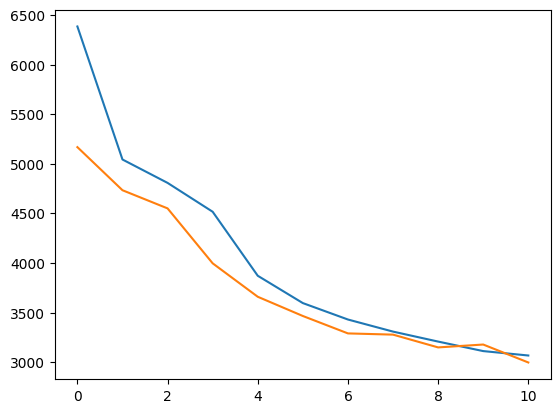

In [185]:
import matplotlib.pyplot as plt
plt.plot(history['train']), plt.plot(history['test'])

In [177]:
model.eval()

UnimolPlusPCQModel(
  (molecule_encoder): UnimolPLusEncoder(
    (layer_norm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
    (pair_layer_norm): LayerNorm(torch.Size([256]), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0): UnimolPlusEncoderLayer(
        (dropout_module): Dropout()
        (self_attn): Attention(
          (linear_q): Linear(in_features=768, out_features=768, bias=False)
          (linear_k): Linear(in_features=768, out_features=768, bias=False)
          (linear_v): Linear(in_features=768, out_features=768, bias=False)
          (linear_o): Linear(in_features=768, out_features=768, bias=True)
          (linear_bias): Linear(in_features=256, out_features=48, bias=True)
        )
        (self_attn_layer_norm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
        (ffn): Transition(
          (linear_1): Linear(in_features=768, out_features=768, bias=True)
          (act): GELU(approximate='none')
        

In [257]:
torch.save(mod.state_dict(), 'unimol_finetune.pt')

In [265]:
# predicts

## more training

In [260]:
mod = mod.train()

In [267]:
optimizer = torch.optim.Adam([*mod.energy_head.parameters(), *mod.solv_nn.parameters()], lr=1e-4)
for epoch in range(num_epochs):        
    train_loss = train()
    test_loss = test()
    history['train'].append(train_loss), history['test'].append(test_loss)
    print(f"Epoch {epoch}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}")

100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [02:19<00:00, 68.13it/s]


Epoch 0, train loss: 2813.0111, test loss: 2737.9726


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [02:19<00:00, 68.17it/s]


Epoch 1, train loss: 2628.3457, test loss: 2860.3333


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [02:20<00:00, 67.74it/s]


Epoch 2, train loss: 2644.2354, test loss: 2869.4325


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [02:21<00:00, 66.94it/s]


Epoch 3, train loss: 2584.0520, test loss: 2855.5879


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [02:28<00:00, 63.87it/s]


Epoch 4, train loss: 2562.9664, test loss: 2898.5116


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [02:18<00:00, 68.59it/s]


Epoch 5, train loss: 2540.2048, test loss: 2702.1864


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [02:17<00:00, 68.99it/s]


Epoch 6, train loss: 2508.4797, test loss: 2739.4809


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [02:18<00:00, 68.77it/s]


Epoch 7, train loss: 2479.5967, test loss: 2648.2573


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [02:17<00:00, 69.15it/s]


Epoch 8, train loss: 2455.8771, test loss: 2755.3026


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [02:17<00:00, 69.24it/s]


Epoch 9, train loss: 2454.9359, test loss: 2674.3197


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [02:17<00:00, 69.29it/s]


Epoch 10, train loss: 2406.2975, test loss: 2659.6675


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [02:16<00:00, 69.44it/s]


Epoch 11, train loss: 2410.5774, test loss: 2641.8604


100%|███████████████████████████████████████████████████████████████████████████████| 9500/9500 [02:16<00:00, 69.80it/s]


Epoch 12, train loss: 2365.2301, test loss: 2502.5213


 22%|█████████████████▋                                                             | 2129/9500 [00:29<01:19, 92.57it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7f9445aee1a0>],
 [<matplotlib.lines.Line2D at 0x7f9445aeeec0>])

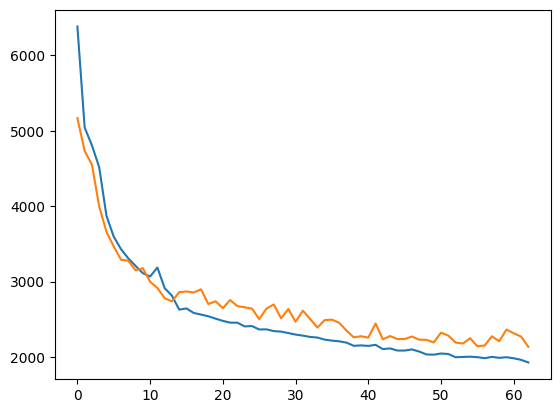

In [268]:
plt.plot(history['train']), plt.plot(history['test'])

In [271]:
test_results = []
for id in df_test.index:
    smiles_mol, smiles_solv, target = get_data(id, df_test)
    target.to(device)
    target = target.to(device)
    pred = mod(smiles_mol, smiles_solv).detach()
    test_results.append([pred, target])

0.8561077303287296

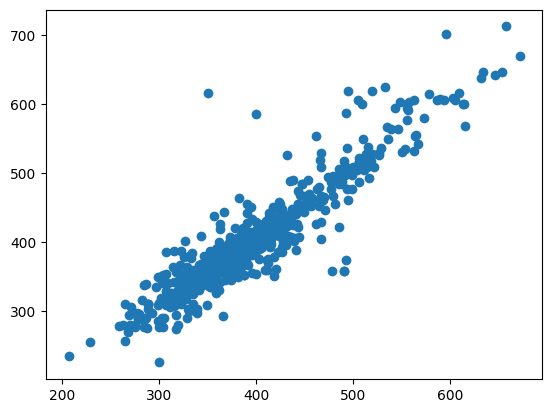

In [275]:
pred_absorbance, ref_absorbance = np.array([float(d[0][0]) for d in test_results]), np.array([float(d[1][0][0]) for d in test_results])
plt.scatter(pred_absorbance, ref_absorbance)
from sklearn.metrics import r2_score
nan_mask = ~np.isnan(ref_absorbance)
r2_score(ref_absorbance[nan_mask], pred_absorbance[nan_mask])

In [270]:
print(1)

1
